In [1]:
import os, datetime, pytz
import pandas as pd
import numpy as np  
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 优先使用中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 使用截取时间
os.environ['train_data_begin_time'] = '09:30:00'
os.environ['train_data_end_time'] = '14:57:00'# 深证 14:57:00 会集合竞价，导致 买卖1档 为0

folder = r'D:\L2_DATA_T0_ETF\his_data'

# 读取数据

In [2]:
# 新特征
def create_derived_features(
    _data: pd.DataFrame, 
    n_levels: int = 10, 
    window: int = 5,
    eps: float = 1e-9
) -> (pd.DataFrame, int):
    """
    基于订单簿快照数据创建一套丰富的衍生特征，以增强高频预测能力。(最终整合版)
    
    该函数融合了两种核心思想：
    1. 静态微观结构特征：描述任一时刻订单簿的形状、深度和压力。
    2. 动态订单流不平衡(OFI)：量化相邻快照间订单流的变化，捕捉市场主动性。

    Args:
        _data (pd.DataFrame): 包含买卖盘数据的DataFrame，
                              列名格式应为 '买i价', '买i量', '卖i价', '卖i量' (i from 1 to n_levels)。
        n_levels (int): 使用的订单簿层级数。
        window (int): 用于计算移动平均和波动率等时间序列特征的窗口大小。
        eps (float): 用于防止除以零的极小值。

    Returns:
        tuple[pd.DataFrame, int]: 
            - pd.DataFrame: 包含所有衍生特征的DataFrame。
            - int: 因时间序列计算而产生的无效数据行数，建议在建模前删除。

    --- 特征体系概览 ---
    1.  核心Level-1特征:
        EXT_mid_price:              中间价，价格基准。
        EXT_relative_spread_l1:     相对买卖价差，流动性成本指标。
        EXT_micro_price:            微观价格，考虑一档订单量的不平衡。
    
    2.  多层次订单簿特征 (存量):
        EXT_total_depth_vol:        总订单簿深度（买+卖）。
        EXT_depth_imbalance:        深度不平衡，衡量整体挂单倾向。
        EXT_wap_bid / EXT_wap_ask:  买/卖方加权平均价，反映平均挂单成本。
        EXT_weighted_mid_price_v1/v2: 基于WAP的加权中间价。
    
    3.  订单簿形状与分布特征 (存量):
        EXT_avg_spread:             多档平均价差。
        EXT_book_slope:             订单簿斜率，衡量价格深度。
        EXT_vol_concentration_l1:   一档订单量集中度。
        EXT_bid/ask_pressure:       价格压力，衡量远离中间价的挂单价值。
        EXT_pressure_imbalance:     价格压力不平衡。
        
    4.  订单流不平衡特征 (OFI - 流量核心):
        EXT_ofi_level_{i}:          第i档的订单流不平衡。
        EXT_total_ofi:              10档OFI的总和。
        EXT_integrated_ofi(未实现):  综合OFI，通过PCA整合10档OFI信息。
        EXT_ofi_imbalance:          OFI不平衡度。

    5.  时间序列特征 (动态):
        EXT_log_ret_...:            多种价格的对数收益率。
        EXT_volatility_...:         基于不同价格的已实现波动率。
        EXT_..._ma / _ewma:         多种指标的移动平均/指数移动平均。
    """
    # --- 0. 基础变量预计算 ---
    bid_prices = [ _data[f'买{i}价'] for i in range(1, n_levels + 1)]
    ask_prices = [ _data[f'卖{i}价'] for i in range(1, n_levels + 1)]
    bid_vols   = [ _data[f'买{i}量'] for i in range(1, n_levels + 1)]
    ask_vols   = [ _data[f'卖{i}量'] for i in range(1, n_levels + 1)]

    df_bid_prices = pd.concat(bid_prices, axis=1)
    df_ask_prices = pd.concat(ask_prices, axis=1)
    df_bid_vols = pd.concat(bid_vols, axis=1)
    df_ask_vols = pd.concat(ask_vols, axis=1)

    features = {}
    
    # --- 1. 核心Level-1特征 ---
    bid_p1, ask_p1 = bid_prices[0], ask_prices[0]
    bid_v1, ask_v1 = bid_vols[0], ask_vols[0]

    features['EXT_mid_price'] = (bid_p1 + ask_p1) / 2
    spread_l1 = ask_p1 - bid_p1
    features['EXT_relative_spread_l1'] = spread_l1 / (features['EXT_mid_price'] + eps)
    total_vol_l1 = bid_v1 + ask_v1
    features['EXT_micro_price'] = (bid_p1 * ask_v1 + ask_p1 * bid_v1) / (total_vol_l1 + eps)
    
    # --- 2. 多层次订单簿特征 (存量) ---
    total_bid_vol = df_bid_vols.sum(axis=1)
    total_ask_vol = df_ask_vols.sum(axis=1)
    
    features['EXT_total_depth_vol'] = total_bid_vol + total_ask_vol
    features['EXT_depth_imbalance'] = (total_bid_vol - total_ask_vol) / (features['EXT_total_depth_vol'] + eps)

    wap_bid_numerator = (df_bid_prices.values * df_bid_vols.values).sum(axis=1)
    wap_ask_numerator = (df_ask_prices.values * df_ask_vols.values).sum(axis=1)
    features['EXT_wap_bid'] = wap_bid_numerator / (total_bid_vol + eps)
    features['EXT_wap_ask'] = wap_ask_numerator / (total_ask_vol + eps)
    
    features['EXT_weighted_mid_price_v1'] = (features['EXT_wap_bid'] + features['EXT_wap_ask']) / 2
    features['EXT_weighted_mid_price_v2'] = (wap_bid_numerator + wap_ask_numerator) / (features['EXT_total_depth_vol'] + eps)

    # --- 3. 订单簿形状与分布特征 (存量) ---
    features['EXT_avg_spread'] = (df_ask_prices.values - df_bid_prices.values).mean(axis=1)
    features['EXT_book_slope'] = (features['EXT_wap_ask'] - features['EXT_wap_bid']) / (features['EXT_mid_price'] + eps)
    features['EXT_vol_concentration_l1'] = total_vol_l1 / (features['EXT_total_depth_vol'] + eps)
    
    mid_price_col = features['EXT_mid_price'].values[:, None]
    bid_pressure = ((mid_price_col - df_bid_prices.values) * df_bid_vols.values).sum(axis=1)
    ask_pressure = ((df_ask_prices.values - mid_price_col) * df_ask_vols.values).sum(axis=1)
    features['EXT_bid_pressure'] = bid_pressure
    features['EXT_ask_pressure'] = ask_pressure
    features['EXT_pressure_imbalance'] = (bid_pressure - ask_pressure) / (bid_pressure + ask_pressure + eps)
    
    # --- 4. 时间序列特征 (动态) ---
    ext_data = pd.DataFrame(features, index=_data.index)

    # === 5. 订单流不平衡特征 (OFI - 流量核心) ===
    # 这是此版本新增的核心模块，需要用到上一时刻的数据，因此首先计算。
    ofi_features = {}
    ofi_cols = []
    
    # 遍历每一档，计算OFI
    for i in range(1, n_levels + 1):
        level = i - 1 # 对应DataFrame的列索引
        # 获取当前和上一个快照的数据
        prev_bid_p = bid_prices[level].shift(1)
        prev_ask_p = ask_prices[level].shift(1)
        prev_bid_v = bid_vols[level].shift(1)
        prev_ask_v = ask_vols[level].shift(1)
            
        # 计算买单侧订单流 OF_b
        conditions_b = [
            bid_prices[level] > prev_bid_p,
            bid_prices[level] < prev_bid_p,
            bid_prices[level] == prev_bid_p
        ]
        choices_b = [
            bid_vols[level],
            -prev_bid_v,
            bid_vols[level] - prev_bid_v
        ]
        of_b = np.select(conditions_b, choices_b, default=0)

        # 计算卖单侧订单流 OF_a
        conditions_a = [
            ask_prices[level] > prev_ask_p,
            ask_prices[level] < prev_ask_p,
            ask_prices[level] == prev_ask_p
        ]
        choices_a = [
            -prev_ask_v,
            ask_vols[level],
            ask_vols[level] - prev_ask_v
        ]
        of_a = np.select(conditions_a, choices_a, default=0)
        
        ofi_col_name = f'EXT_ofi_level_{i}'
        ofi_features[ofi_col_name] = of_b - of_a
        ofi_cols.append(ofi_col_name)

    df_ofi = pd.DataFrame(ofi_features, index=_data.index)
    
    # 计算OFI的聚合特征
    total_ofi_bid = df_ofi[[f'EXT_ofi_level_{i}' for i in range(1, n_levels + 1)]].where(df_ofi > 0).sum(axis=1)
    total_ofi_ask = df_ofi[[f'EXT_ofi_level_{i}' for i in range(1, n_levels + 1)]].where(df_ofi < 0).sum(axis=1).abs()
    
    df_ofi['EXT_total_ofi'] = df_ofi[ofi_cols].sum(axis=1)
    df_ofi['EXT_ofi_imbalance'] = (total_ofi_bid - total_ofi_ask) / (total_ofi_bid + total_ofi_ask + eps)
    
    # 暂时不使用 TODO
    # # 计算综合OFI (Integrated OFI) - 论文核心创新
    # ofi_vectors = df_ofi[ofi_cols].fillna(0).values
    # # 注意: PCA应在训练集上fit，这里为简化流程在全局fit。
    # # 在实际应用中，应先划分数据，再在训练集上fit PCA和StandardScaler。
    # scaler_ofi = StandardScaler()
    # pca_ofi = PCA(n_components=1)
    # scaled_ofi_vectors = scaler_ofi.fit_transform(ofi_vectors)
    # df_ofi['EXT_integrated_ofi'] = pca_ofi.fit_transform(scaled_ofi_vectors)

    # 将OFI特征合并到主DataFrame中
    ext_data = pd.concat([ext_data, df_ofi], axis=1)

    ext_data['EXT_log_ret_mid_price'] = np.log(ext_data['EXT_mid_price']).diff()
    ext_data['EXT_log_ret_micro_price'] = np.log(ext_data['EXT_micro_price']).diff()
    ext_data['EXT_log_ret_wap'] = np.log(ext_data['EXT_wap_bid']).diff() # 使用wap_bid作为WAP代表
    
    ext_data[f'EXT_volatility_{window}'] = ext_data['EXT_log_ret_mid_price'].rolling(window=window).std()
    ext_data[f'EXT_volatility_wap_{window}'] = ext_data['EXT_log_ret_wap'].rolling(window=window).std()

    ext_data[f'EXT_relative_spread_l1_ma_{window}'] = ext_data['EXT_relative_spread_l1'].rolling(window=window).mean()
    ext_data[f'EXT_relative_spread_l1_ewma_{window}'] = ext_data['EXT_relative_spread_l1'].ewm(span=window, adjust=False).mean()
    ext_data[f'EXT_mid_price_ewma_{window}'] = ext_data['EXT_mid_price'].ewm(span=window, adjust=False).mean()
    
    # --- 6. 清理与返回 ---
    # 对于滚动计算和diff产生的NaN，使用前向填充(ffill)是合理的策略
    ext_data.ffill(inplace=True)
    # 填充完后，开头仍然可能存在NaN，用0填充
    ext_data.fillna(0, inplace=True)
    ext_data.replace([np.inf, -np.inf], 0, inplace=True)
    
    # 智能计算需要删除的无效行数
    theoretical_invalid_rows = max(
        1,  # diff() 和 shift(1) 操作产生的NaN数量
        window - 1  # rolling(window) 操作产生的NaN数量
    )
    
    # 实际应用中，首行的OFI因为没有前一刻数据而无效，因此至少要删除1行
    # 加上滚动窗口的影响，最终无效行数由window决定
    final_invalid_rows = theoretical_invalid_rows
    
    # 注意：不在此处删除行，而是返回行数，让调用者根据训练/测试逻辑决定如何处理
    return ext_data, final_invalid_rows

def fix_raw_data(date, code):
    """
    数据预处理
    """
    print(f'fix_raw_data: {date} {code}', flush=True)

    file = os.path.join(folder, date, code, '十档盘口.csv')
    begin_t = os.environ.get('train_data_begin_time', '09:30')
    end_t = os.environ.get('train_data_end_time', '14:45')

    if os.path.exists(file):
        _data = pd.read_csv(file, encoding='gbk')

        # 删除完全重复的行
        _data = _data.drop_duplicates(keep='first')

        # 格式化 时间
        _data['时间'] = pd.to_datetime(_data['时间'])
        # 截取 10:00 - 14:30
        _data = _data[(_data["时间"].dt.time >= pd.to_datetime(begin_t).time()) & (
            _data["时间"].dt.time < pd.to_datetime(end_t).time())].reset_index(drop=True)
        _data = _data[(_data["时间"].dt.time <= pd.to_datetime('11:30:00').time()) | (
            _data["时间"].dt.time > pd.to_datetime('13:00:00').time())].reset_index(drop=True)
        if len(_data) == 0:
            print(f'fix_raw_data: {date} {code} 没有数据')
            return

        # 判断是否有 涨跌停
        # 涨跌停 不使用
        zt = ((_data['卖1价'] == 0) & (_data['卖1量'] == 0)).any()
        dt = ((_data['买1价'] == 0) & (_data['买1量'] == 0)).any()
        if zt or dt:
            print(f'fix_raw_data: {date} {code} 存在涨跌停')
            return

        _data = _data.reset_index(drop=True)

        # 删除列 '卖1价' 和 '买1价' 中存在 NaN 值的行
        # _data = _data.dropna(subset=['卖1价', '买1价']).reset_index(drop=True)
        # 暂时不允许 '卖1价', '买1价' 存在 NaN
        msg = ''
        if _data['卖1价'].isna().any():
            msg += f'{date} {code} 卖1价存在 NaN\n'
        if _data['买1价'].isna().any():
            msg += f'{date} {code} 买1价存在 NaN\n'
        if msg:
            raise Exception(msg)

        # 可以容忍的异常值处理
        # 2-10 档位价格nan填充, 使用上一个档位数据 +-0.001 进行填充
        for i in range(2, 11):
            # 买价
            _data.loc[:, f'买{i}价'] = _data[f'买{i}价'].fillna(_data[f'买{i-1}价'] - 0.001)
            # 卖价
            _data.loc[:, f'卖{i}价'] = _data[f'卖{i}价'].fillna(_data[f'卖{i-1}价'] + 0.001)
        # 盘口量nan与0都用1填充
        vol_cols = [i for i in list(_data) if '量' in i]
        _data[vol_cols] = _data[vol_cols].replace(0, np.nan).fillna(1)

        # 格式化 总卖 总买
        for col in ['总卖', '总买']:
            try:
                _data[col] = _data[col].astype(float)
            except:
                _data[col] = _data[col].apply(
                    lambda x: 10000 * (float(x.replace("万", "")))
                    if "万" in str(x)
                    else 1e8 * (float(x.replace("亿", "")))
                    if "亿" in str(x)
                    else float(x)
                )

        data = _data

        # 信息数据 2
        # 距离市场关闭的秒数
        dt = datetime.datetime.strptime(f'{date} 15:00:00', '%Y%m%d %H:%M:%S')
        dt = pytz.timezone('Asia/Shanghai').localize(dt)
        close_ts = int(dt.timestamp())
        time_series = data['时间'].dt.tz_localize('Asia/Shanghai')
        time_timestamps = time_series.astype(np.int64) // 10**9  # 转换为秒级时间戳

        info_data = pd.DataFrame({
            '距离收盘秒数': close_ts - time_timestamps,
            '时间' : data['时间'],
        })

        # 衍生特征
        ext_data, final_invalid_rows = create_derived_features(data)

        # 原始数据 40 
        # 原始价量数据 + 信息数据
        base_data_all_cols = [
            '卖1价', '卖1量', '买1价', '买1量', '卖2价', '卖2量', '买2价', '买2量', '卖3价', '卖3量', '买3价', '买3量', '卖4价', '卖4量', '买4价', '买4量', '卖5价', '卖5量', '买5价', '买5量', '卖6价', '卖6量', '买6价', '买6量', '卖7价', '卖7量', '买7价', '买7量', '卖8价', '卖8量', '买8价', '买8量', '卖9价', '卖9量', '买9价', '买9量', '卖10价', '卖10量', '买10价', '买10量'
        ]
        base_data = data.loc[:, base_data_all_cols].copy()
        # 更改列名
        base_data.columns = ['BASE' + i for i in list(base_data)]

        # 拼接数据
        result = pd.concat([base_data, ext_data, info_data], axis=1)

        # 清理无效数据
        if final_invalid_rows > 0:
            result = result.iloc[final_invalid_rows:].reset_index(drop=True)

        # nan/inf 检查
        has_nan = result.isna().any().any()
        has_inf = (result == float('inf')).any().any()
        if has_nan or has_inf:
            # 发送微信提醒 
            msg = f'{date} {code} fix数据 包含 NaN 或 Inf'
            raise Exception(msg)

        return result

    else:
        print(f'{date} {code} 没有数据, {file} 不存在')


In [3]:
# # 旧特征
# def calculate_order_flow_imbalance(
#     data: pd.DataFrame, 
#     n_levels: int = 10
# ) -> pd.Series:
#     """
#     基于订单簿快照，严谨地计算订单流不平衡 (Order Flow Imbalance, OFI)。

#     该实现严格遵循OFI的定义，处理价格变动时的订单流计算。

#     Args:
#         data (pd.DataFrame): 包含连续订单簿快照的DataFrame。
#                              列名应为 '买i价', '买i量', '卖i价', '卖i量'。
#         n_levels (int): 计算OFI时考虑的订单簿层级数。

#     Returns:
#         pd.Series: 代表每个时间点的净订单流不平衡 (OFI) 的Series。
#     """
#     # 获取 t-1 时刻的数据
#     prev_data = data.shift(1)

#     # 初始化总的买方和卖方订单流
#     total_bOF = pd.Series(0.0, index=data.index)
#     total_aOF = pd.Series(0.0, index=data.index)

#     for i in range(1, n_levels + 1):
#         # 定义列名
#         bid_price_col, bid_vol_col = f'买{i}价', f'买{i}量'
#         ask_price_col, ask_vol_col = f'卖{i}价', f'卖{i}量'

#         # 获取 t 和 t-1 时刻的价格与量
#         b_p, b_v = data[bid_price_col], data[bid_vol_col]
#         a_p, a_v = data[ask_price_col], data[ask_vol_col]
        
#         prev_b_p, prev_b_v = prev_data[bid_price_col], prev_data[bid_vol_col]
#         prev_a_p, prev_a_v = prev_data[ask_price_col], prev_data[ask_vol_col]

#         # --- 使用 np.select 计算买方订单流 (bOF_i) ---
#         bOF_conditions = [
#             b_p > prev_b_p,   # 价格上移
#             b_p < prev_b_p,   # 价格下移
#             b_p == prev_b_p   # 价格不变 (作为默认情况或最后一个条件)
#         ]
#         bOF_choices = [
#             b_v,              # 流量 = 新订单的量
#             -prev_b_v,        # 流量 = 消失的旧订单的量 (负数)
#             b_v - prev_b_v    # 流量 = 量的净变化
#         ]
#         bOF_i = np.select(bOF_conditions, bOF_choices, default=0)
        
#         # --- 使用 np.select 计算卖方订单流 (aOF_i) ---
#         aOF_conditions = [
#             a_p < prev_a_p,   # 价格下移
#             a_p > prev_a_p,   # 价格上移
#             a_p == prev_a_p   # 价格不变
#         ]
#         aOF_choices = [
#             a_v,              # 流量 = 新卖单的量 (代表卖压)
#             -prev_a_v,        # 流量 = 消失的旧卖单的量 (负数，代表卖压减小)
#             a_v - prev_a_v    # 流量 = 量的净变化
#         ]
#         aOF_i = np.select(aOF_conditions, aOF_choices, default=0)

#         # 累加每一层的订单流
#         total_bOF += bOF_i
#         total_aOF += aOF_i

#     # OFI = 总买方订单流 - 总卖方订单流
#     # 注意：aOF 本身代表卖压，所以用减法
#     ofi = total_bOF - total_aOF
    
#     # 第一个值因为 shift() 会是 NaN，用0填充
#     return ofi.fillna(0)

# def create_derived_features(
#     _data: pd.DataFrame, 
#     n_levels: int = 10, 
#     window: int = 5,
#     eps: float = 1e-9
# ) -> pd.DataFrame:
#     """
#     基于订单簿数据创建衍生特征，以增强预测能力。(优化版)

#     Args:
#         _data (pd.DataFrame): 包含买卖盘数据的DataFrame，
#                               列名应为 '买i价', '买i量', '卖i价', '卖i量' (i from 1 to n_levels)。
#         n_levels (int): 使用的订单簿层级数。
#         window (int): 用于计算移动平均和波动率的时间窗口。
#         eps (float): 用于防止除以零的极小值。

#     spread 相关指标容易产生极端偏离值: 大多数 spread=0.001, 零星出现的 spread=0.002，会导致零星的 极端值
#     暂时不使用
#         EXT_relative_spread_l1
#         EXT_avg_spread
#         EXT_relative_spread_l1_ma_{window}
#         EXT_relative_spread_l1_ewma_{window}

#     Returns:
#         pd.DataFrame: 包含所有衍生特征的DataFrame。

#         1. 核心Level-1特征
#             EXT_mid_price
#             EXT_relative_spread_l1
#             EXT_micro_price
#         2. 多层次订单簿特征
#             EXT_total_depth_vol
#             EXT_depth_imbalance
#             EXT_wap_bid
#             EXT_wap_ask
#             EXT_weighted_mid_price_v1
#             EXT_weighted_mid_price_v2
#         3. 订单簿形状与分布特征
#             EXT_avg_spread
#             EXT_book_slope
#             EXT_vol_concentration_l1
#             EXT_bid_pressure
#             EXT_ask_pressure
#             EXT_pressure_imbalance
#         4. 时间序列特征
#             EXT_log_ret_mid_price
#             EXT_log_ret_micro_price
#             EXT_volatility_5
#             EXT_log_ret_wap
#             EXT_volatility_wap_5
#             EXT_relative_spread_l1_ma_5
#             EXT_relative_spread_l1_ewma_5
#             EXT_mid_price_ewma_5
#             EXT_ofi
        
#     """
#     # --- 0. 基础变量预计算 ---
#     bid_prices = [ _data[f'买{i}价'] for i in range(1, n_levels + 1)]
#     ask_prices = [ _data[f'卖{i}价'] for i in range(1, n_levels + 1)]
#     bid_vols   = [ _data[f'买{i}量'] for i in range(1, n_levels + 1)]
#     ask_vols   = [ _data[f'卖{i}量'] for i in range(1, n_levels + 1)]

#     df_bid_prices = pd.concat(bid_prices, axis=1)
#     df_ask_prices = pd.concat(ask_prices, axis=1)
#     df_bid_vols = pd.concat(bid_vols, axis=1)
#     df_ask_vols = pd.concat(ask_vols, axis=1)

#     features = {}

#     # --- 1. 核心Level-1特征 ---
#     bid_p1, ask_p1 = bid_prices[0], ask_prices[0]
#     bid_v1, ask_v1 = bid_vols[0], ask_vols[0]

#     features['EXT_mid_price'] = (bid_p1 + ask_p1) / 2
    
#     # 移除了 EXT_spread_l1，但保留了相对价差，因为它经过中间价归一化，方差通常不为0
#     spread_l1 = ask_p1 - bid_p1
#     features['EXT_relative_spread_l1'] = spread_l1 / (features['EXT_mid_price'] + eps)
    
#     total_vol_l1 = bid_v1 + ask_v1
#     features['EXT_micro_price'] = (bid_p1 * ask_v1 + ask_p1 * bid_v1) / (total_vol_l1 + eps)
    
#     # [已移除] EXT_obi_l1, EXT_vol_l1, EXT_vol_l1_ratio
#     # 它们的信息被更高级的特征所涵盖

#     # --- 2. 多层次订单簿特征 ---
#     total_bid_vol = df_bid_vols.sum(axis=1)
#     total_ask_vol = df_ask_vols.sum(axis=1)
    
#     features['EXT_total_depth_vol'] = total_bid_vol + total_ask_vol
#     features['EXT_depth_imbalance'] = (total_bid_vol - total_ask_vol) / (features['EXT_total_depth_vol'] + eps)

#     wap_bid_numerator = (df_bid_prices.values * df_bid_vols.values).sum(axis=1)
#     wap_ask_numerator = (df_ask_prices.values * df_ask_vols.values).sum(axis=1)
#     wap_bid = wap_bid_numerator / (total_bid_vol + eps)
#     wap_ask = wap_ask_numerator / (total_ask_vol + eps)
#     features['EXT_wap_bid'] = wap_bid
#     features['EXT_wap_ask'] = wap_ask
    
#     features['EXT_weighted_mid_price_v1'] = (wap_bid + wap_ask) / 2
#     features['EXT_weighted_mid_price_v2'] = (wap_bid_numerator + wap_ask_numerator) / (features['EXT_total_depth_vol'] + eps)

#     # --- 3. 订单簿形状与分布特征 ---
#     features['EXT_avg_spread'] = (df_ask_prices.values - df_bid_prices.values).mean(axis=1)
#     features['EXT_book_slope'] = (wap_ask - wap_bid) / (features['EXT_mid_price'] + eps)
#     # [修改] 分母使用 total_depth_vol 而非被移除的 vol_l1
#     features['EXT_vol_concentration_l1'] = total_vol_l1 / (features['EXT_total_depth_vol'] + eps)
    
#     # [新增] 价格压力特征 (Price Pressure)
#     mid_price_col = features['EXT_mid_price'].values[:, None]
#     bid_pressure = ((mid_price_col - df_bid_prices.values) * df_bid_vols.values).sum(axis=1)
#     ask_pressure = ((df_ask_prices.values - mid_price_col) * df_ask_vols.values).sum(axis=1)
#     features['EXT_bid_pressure'] = bid_pressure
#     features['EXT_ask_pressure'] = ask_pressure
#     features['EXT_pressure_imbalance'] = (bid_pressure - ask_pressure) / (bid_pressure + ask_pressure + eps)
    
#     # --- 4. 时间序列特征 ---
#     ext_data = pd.DataFrame(features, index=_data.index)

#     ext_data['EXT_log_ret_mid_price'] = np.log(ext_data['EXT_mid_price']).diff()
#     ext_data['EXT_log_ret_micro_price'] = np.log(ext_data['EXT_micro_price']).diff()
    
#     # [已移除] EXT_log_diff_vol_l1, EXT_diff_spread_l1, EXT_diff_obi_l1

#     ext_data[f'EXT_volatility_{window}'] = ext_data['EXT_log_ret_mid_price'].rolling(window=window).std()
    
#     # [新增] 基于WAP的波动率，更稳健
#     ext_data['EXT_log_ret_wap'] = np.log(ext_data['EXT_wap_bid']).diff()
#     ext_data[f'EXT_volatility_wap_{window}'] = ext_data['EXT_log_ret_wap'].rolling(window=window).std()

#     # [已移除] 基于obi_l1的移动平均
#     # 保留基于相对价差的移动平均，因为它更不容易为0
#     ext_data[f'EXT_relative_spread_l1_ma_{window}'] = ext_data['EXT_relative_spread_l1'].rolling(window=window).mean()
#     ext_data[f'EXT_relative_spread_l1_ewma_{window}'] = ext_data['EXT_relative_spread_l1'].ewm(span=window, adjust=False).mean()
    
#     # 保留基于mid_price的EWMA，因为它是一个重要的平滑价格指标
#     ext_data[f'EXT_mid_price_ewma_{window}'] = ext_data['EXT_mid_price'].ewm(span=window, adjust=False).mean()

#     # --- 5. 订单流特征 ---
#     ext_data['EXT_ofi'] = calculate_order_flow_imbalance(_data)

#     # --- 6. 清理与返回 ---
#     # 对于滚动计算产生的NaN，使用前向填充(ffill)通常比填充0更合理，因为它延续了上一个时间点的状态
#     # 之后仍然可能存在开头几个NaN，再用0填充
#     ext_data.ffill(inplace=True)
#     ext_data.fillna(0, inplace=True)
    
#     # 替换可能因eps极小而产生的inf（理论上不会，但作为保险）
#     ext_data.replace([np.inf, -np.inf], 0, inplace=True)
    
#     # {{ AURA-X | Action: Modify | Reason: 智能检测无效数据点，基于window参数和实际数据质量动态计算 | Approval: Cunzhi }}
#     # 智能计算需要删除的无效行数
#     # 1. 基于时间序列操作的理论需求
#     theoretical_invalid_rows = max(
#         1,  # diff() 操作产生的NaN数量
#         window - 1  # rolling(window) 操作产生的NaN数量
#     )
    
#     # 2. 动态检测实际的低质量数据行
#     actual_invalid_rows = 0
#     if len(ext_data) > 0:
#         # 检测前几行的数据质量
#         max_check_rows = min(theoretical_invalid_rows + 2, len(ext_data))
#         for idx in range(max_check_rows):
#             row = ext_data.iloc[idx]
#             # 检测NaN或异常的0值比例
#             nan_count = row.isna().sum()
#             zero_count = (row == 0).sum()
#             total_features = len(row)
            
#             # 如果NaN或0值占比超过30%，认为是低质量数据
#             if (nan_count + zero_count) / total_features > 0.3:
#                 actual_invalid_rows = idx + 1
#             else:
#                 break
    
#     # 3. 使用理论值和实际检测值的最大值
#     final_invalid_rows = max(theoretical_invalid_rows, actual_invalid_rows)
    
#     return ext_data, final_invalid_rows

# def fix_raw_data(date, code):
#     """
#     数据预处理
#     """
#     print(f'fix_raw_data: {date} {code}', flush=True)

#     file = os.path.join(folder, date, code, '十档盘口.csv')
#     begin_t = os.environ.get('train_data_begin_time', '09:30')
#     end_t = os.environ.get('train_data_end_time', '14:45')

#     if os.path.exists(file):
#         _data = pd.read_csv(file, encoding='gbk')

#         # 删除完全重复的行
#         _data = _data.drop_duplicates(keep='first')

#         # 格式化 时间
#         _data['时间'] = pd.to_datetime(_data['时间'])
#         # 截取 10:00 - 14:30
#         _data = _data[(_data["时间"].dt.time >= pd.to_datetime(begin_t).time()) & (
#             _data["时间"].dt.time < pd.to_datetime(end_t).time())].reset_index(drop=True)
#         _data = _data[(_data["时间"].dt.time <= pd.to_datetime('11:30:00').time()) | (
#             _data["时间"].dt.time > pd.to_datetime('13:00:00').time())].reset_index(drop=True)
#         if len(_data) == 0:
#             print(f'fix_raw_data: {date} {code} 没有数据')
#             return

#         # 判断是否有 涨跌停
#         # 涨跌停 不使用
#         zt = ((_data['卖1价'] == 0) & (_data['卖1量'] == 0)).any()
#         dt = ((_data['买1价'] == 0) & (_data['买1量'] == 0)).any()
#         if zt or dt:
#             print(f'fix_raw_data: {date} {code} 存在涨跌停')
#             return

#         _data = _data.reset_index(drop=True)

#         # 删除列 '卖1价' 和 '买1价' 中存在 NaN 值的行
#         # _data = _data.dropna(subset=['卖1价', '买1价']).reset_index(drop=True)
#         # 暂时不允许 '卖1价', '买1价' 存在 NaN
#         msg = ''
#         if _data['卖1价'].isna().any():
#             msg += f'{date} {code} 卖1价存在 NaN\n'
#         if _data['买1价'].isna().any():
#             msg += f'{date} {code} 买1价存在 NaN\n'
#         if msg:
#             raise Exception(msg)

#         # 可以容忍的异常值处理
#         # 2-10 档位价格nan填充, 使用上一个档位数据 +-0.001 进行填充
#         for i in range(2, 11):
#             # 买价
#             _data.loc[:, f'买{i}价'] = _data[f'买{i}价'].fillna(_data[f'买{i-1}价'] - 0.001)
#             # 卖价
#             _data.loc[:, f'卖{i}价'] = _data[f'卖{i}价'].fillna(_data[f'卖{i-1}价'] + 0.001)
#         # 盘口量nan与0都用1填充
#         vol_cols = [i for i in list(_data) if '量' in i]
#         _data[vol_cols] = _data[vol_cols].replace(0, np.nan).fillna(1)

#         # 格式化 总卖 总买
#         for col in ['总卖', '总买']:
#             try:
#                 _data[col] = _data[col].astype(float)
#             except:
#                 _data[col] = _data[col].apply(
#                     lambda x: 10000 * (float(x.replace("万", "")))
#                     if "万" in str(x)
#                     else 1e8 * (float(x.replace("亿", "")))
#                     if "亿" in str(x)
#                     else float(x)
#                 )

#         data = _data

#         # 信息数据 2
#         # 距离市场关闭的秒数
#         dt = datetime.datetime.strptime(f'{date} 15:00:00', '%Y%m%d %H:%M:%S')
#         dt = pytz.timezone('Asia/Shanghai').localize(dt)
#         close_ts = int(dt.timestamp())
#         time_series = data['时间'].dt.tz_localize('Asia/Shanghai')
#         time_timestamps = time_series.astype(np.int64) // 10**9  # 转换为秒级时间戳

#         info_data = pd.DataFrame({
#             '距离收盘秒数': close_ts - time_timestamps,
#             '时间' : data['时间'],
#         })

#         # 衍生特征
#         ext_data, final_invalid_rows = create_derived_features(data)

#         # 原始数据 40 
#         # 原始价量数据 + 信息数据
#         base_data_all_cols = [
#             '卖1价', '卖1量', '买1价', '买1量', '卖2价', '卖2量', '买2价', '买2量', '卖3价', '卖3量', '买3价', '买3量', '卖4价', '卖4量', '买4价', '买4量', '卖5价', '卖5量', '买5价', '买5量', '卖6价', '卖6量', '买6价', '买6量', '卖7价', '卖7量', '买7价', '买7量', '卖8价', '卖8量', '买8价', '买8量', '卖9价', '卖9量', '买9价', '买9量', '卖10价', '卖10量', '买10价', '买10量'
#         ]
#         base_data = data.loc[:, base_data_all_cols].copy()
#         # 更改列名
#         base_data.columns = ['BASE' + i for i in list(base_data)]

#         # 拼接数据
#         result = pd.concat([base_data, ext_data, info_data], axis=1)

#         # 清理无效数据
#         if final_invalid_rows > 0:
#             result = result.iloc[final_invalid_rows:].reset_index(drop=True)

#         # nan/inf 检查
#         has_nan = result.isna().any().any()
#         has_inf = (result == float('inf')).any().any()
#         if has_nan or has_inf:
#             # 发送微信提醒 
#             msg = f'{date} {code} fix数据 包含 NaN 或 Inf'
#             raise Exception(msg)

#         return result
#     else:
#         print(f'{date} {code} 没有数据, {file} 不存在')


In [4]:
code = '513180'

all_dates = os.listdir(folder)
date = random.choice(all_dates)

code, date = '513180 20240422'.split()
print(code, date)

raw_data = fix_raw_data(date, code)
raw_data.head()

513180 20240422
fix_raw_data: 20240422 513180


,BASE卖1价,BASE卖1量,BASE买1价,BASE买1量,BASE卖2价,BASE卖2量,BASE买2价,BASE买2量,BASE卖3价,BASE卖3量,...,EXT_log_ret_micro_price,EXT_volatility_5,EXT_log_ret_wap,EXT_volatility_wap_5,EXT_relative_spread_l1_ma_5,EXT_relative_spread_l1_ewma_5,EXT_mid_price_ewma_5,EXT_ofi,距离收盘秒数,时间
0,0.45,1230636,0.449,208361,0.451,300194,0.448,501025,0.452,307035,...,0.000010,0.0,0.000054,0.000000,0.002225,0.002225,0.4495,-1351.0,19787,2024-04-22 09:30:13
1,0.45,521539,0.449,249383,0.451,318527,0.448,504675,0.452,306541,...,0.000398,0.0,0.000120,0.000468,0.002225,0.002225,0.4495,769331.0,19784,2024-04-22 09:30:16
2,0.45,543503,0.449,207599,0.451,324227,0.448,506598,0.452,389701,...,-0.000105,0.0,-0.000125,0.000148,0.002225,0.002225,0.4495,-158094.0,19781,2024-04-22 09:30:19
3,0.45,548770,0.449,132222,0.451,329513,0.448,502733,0.452,393773,...,-0.000183,0.0,-0.000241,0.000161,0.002225,0.002225,0.4495,-87202.0,19778,2024-04-22 09:30:22
4,0.45,570185,0.449,23282,0.451,330448,0.448,445054,0.452,393694,...,-0.000345,0.0,-0.000554,0.000268,0.002225,0.002225,0.4495,-173063.0,19775,2024-04-22 09:30:25


In [5]:
raw_data['spread'] = raw_data['BASE卖1价'] - raw_data['BASE买1价']

In [6]:
raw_data.to_csv('raw_data.csv', index=False, encoding='gbk')

In [7]:
CLIP_PERCENTILE = 99.9

vol_cols = [col for col in raw_data.columns if '量' in col and 'BASE' in col]
base_vol_data = raw_data[vol_cols].copy()
print(pd.Series(base_vol_data.values.flatten()).describe())
clip_threshold = np.percentile(base_vol_data.values.flatten(), CLIP_PERCENTILE)
print(clip_threshold)
base_vol_data = base_vol_data.clip(upper=clip_threshold)
base_vol_data

count    9.470000e+04
mean     4.245307e+05
std      3.305329e+05
min      1.610000e+03
25%      1.327580e+05
50%      3.520660e+05
75%      6.231780e+05
max      1.785573e+06
dtype: float64
1552923.3310000002


,BASE卖1量,BASE买1量,BASE卖2量,BASE买2量,BASE卖3量,BASE买3量,BASE卖4量,BASE买4量,BASE卖5量,BASE买5量,BASE卖6量,BASE买6量,BASE卖7量,BASE买7量,BASE卖8量,BASE买8量,BASE卖9量,BASE买9量,BASE卖10量,BASE买10量
0,1230636,208361.0,300194,501025,307035,374191,301949,318297,279905,292937,151184,238185,63782,99913,42066,157092,38975,133658,51345,150600
1,521539,249383.0,318527,504675,306541,377759,306358,322835,286464,295351,117360,248733,72190,100387,43260,157732,40066,133708,53174,151435
2,543503,207599.0,324227,506598,389701,377477,306581,321564,290165,296692,117723,248762,73090,100487,43275,157762,40522,132758,54192,151705
3,548770,132222.0,329513,502733,393773,386267,307670,321573,290165,296662,118723,248752,73090,100482,43275,157762,40522,132758,54192,151705
4,570185,23282.0,330448,445054,393694,386190,307670,321788,290165,296662,114023,259741,73090,100482,43275,157762,40522,132758,54192,151705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4730,33457,1277419.0,1357219,524809,763463,437535,573895,134442,346775,94925,297369,114742,276976,81682,419021,60104,75162,8298,89553,14324
4731,1346148,17464.0,763029,1283573,564370,519886,346775,437535,297369,134442,276976,94925,419021,114742,75162,81682,89553,60104,50428,8298
4732,1351855,10305.0,763029,1286973,564370,519490,346775,437535,297369,134442,276976,94925,419021,114742,75162,81682,89553,60104,50428,8298
4733,1352651,22330.0,765029,1261069,564370,518690,346725,437535,297319,134442,276926,94925,418971,114742,75162,81682,89553,60104,50428,8248


In [8]:
base_vol_data.values.flatten()

array([1230636.,  208361.,  300194., ...,   60104.,   50428.,    8248.],
      shape=(94700,))

# 检查数据

In [9]:
# 使用 .describe() 对关键列进行描述
raw_data.describe().to_csv(r'C:\Users\lh\AppData\Local\Temp\raw_data_describe.csv', encoding='gbk')

In [10]:
# 检查是否存在负价差（严重错误）或价差过大的情况。
# 只绘制价差>0.001的数据
filtered_spreads = raw_data[raw_data['spread'] > 0.0012]['spread']
if not filtered_spreads.empty:
    print(f'价差 > 0.001 的数据描述:')
    print(filtered_spreads.describe())
else:
    print("没有找到价差 > 0.001 的数据")

print(f'')

# 查找异常价差 
# <= 0
negative_spreads = raw_data[raw_data['spread'] <= 0]
print(f"发现 {len(negative_spreads)} 笔负价差或零价差记录。")
if not negative_spreads.empty:
    print("异常记录详情:")
    print(negative_spreads[['BASE卖1价', 'BASE买1价', 'spread']])



价差 > 0.001 的数据描述:
count    1.000
mean     0.002
std        NaN
min      0.002
25%      0.002
50%      0.002
75%      0.002
max      0.002
Name: spread, dtype: float64

发现 0 笔负价差或零价差记录。


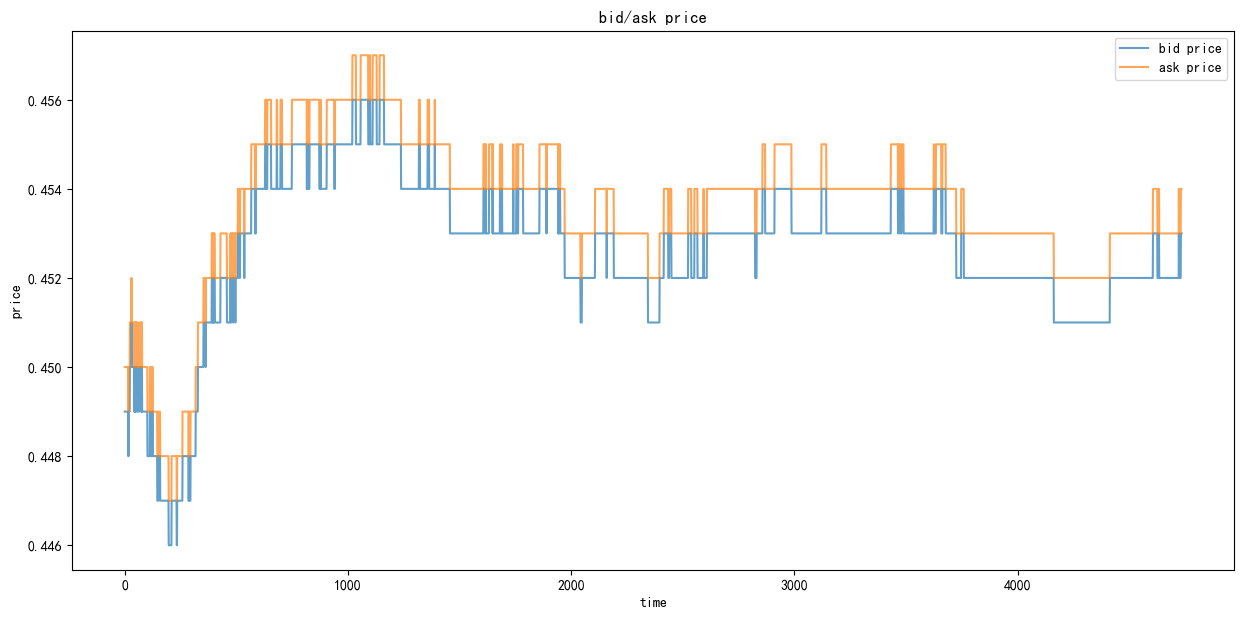

In [11]:
# 直观地发现价格序列中的异常点（毛刺/Spikes）。
plt.figure(figsize=(15, 7))
plt.plot(raw_data.index, raw_data['BASE买1价'], label='bid price', alpha=0.7)
plt.plot(raw_data.index, raw_data['BASE卖1价'], label='ask price', alpha=0.7)
plt.title('bid/ask price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()


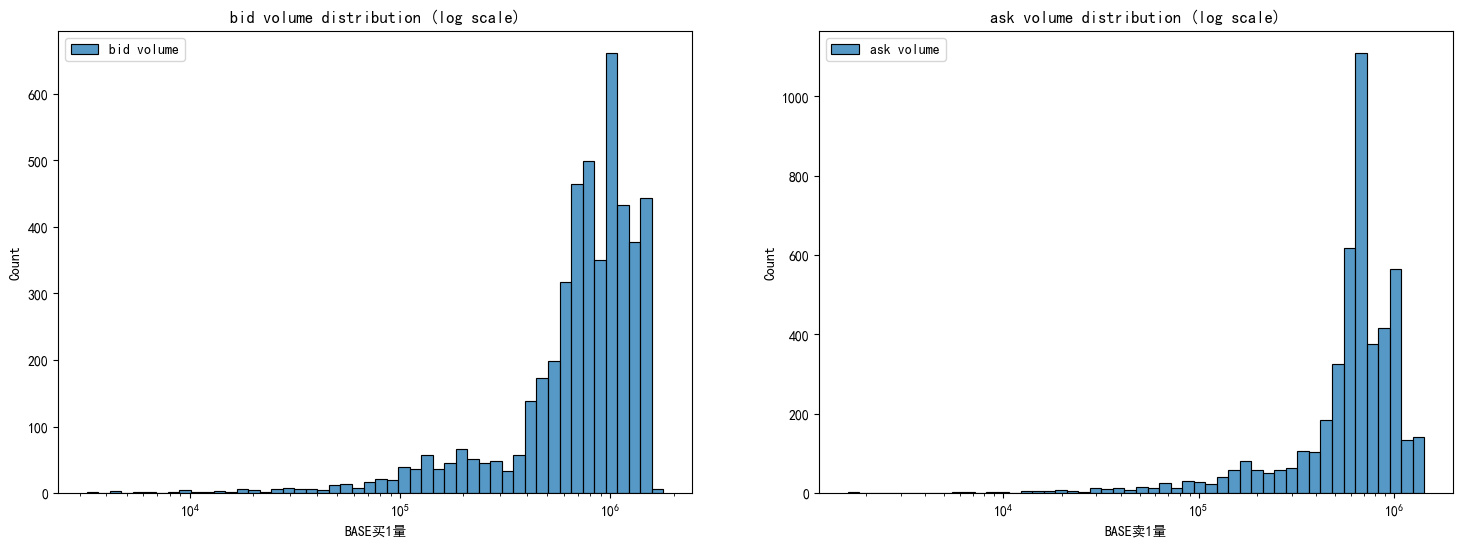


发现 0 笔零挂单量记录。
发现 4 笔异常大挂单量记录。
异常大挂单量详情:
      BASE买1量  BASE卖1量                  时间
2397  1785573    84018 2024-04-22 13:00:04
2398  1643620    95714 2024-04-22 13:00:07
3996  1578434   590508 2024-04-22 14:20:04
3999  1578934   583545 2024-04-22 14:20:13


In [12]:
# 检查成交量的分布，寻找异常的极大值或零值。
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(raw_data['BASE买1量'], bins=50, ax=axes[0], log_scale=True, label='bid volume')
axes[0].set_title('bid volume distribution (log scale)')
sns.histplot(raw_data['BASE卖1量'], bins=50, ax=axes[1], log_scale=True, label='ask volume')
axes[1].set_title('ask volume distribution (log scale)')
axes[0].legend()
axes[1].legend()
plt.show()

# 查找异常成交量
zero_volume = raw_data[(raw_data['BASE买1量'] == 0) | (raw_data['BASE卖1量'] == 0)]
large_volume = raw_data[raw_data['BASE买1量'] > raw_data['BASE买1量'].quantile(0.999)]

print(f"\n发现 {len(zero_volume)} 笔零挂单量记录。")
print(f"发现 {len(large_volume)} 笔异常大挂单量记录。")
if not large_volume.empty:
    print("异常大挂单量详情:")
    print(large_volume[['BASE买1量', 'BASE卖1量', '时间']])

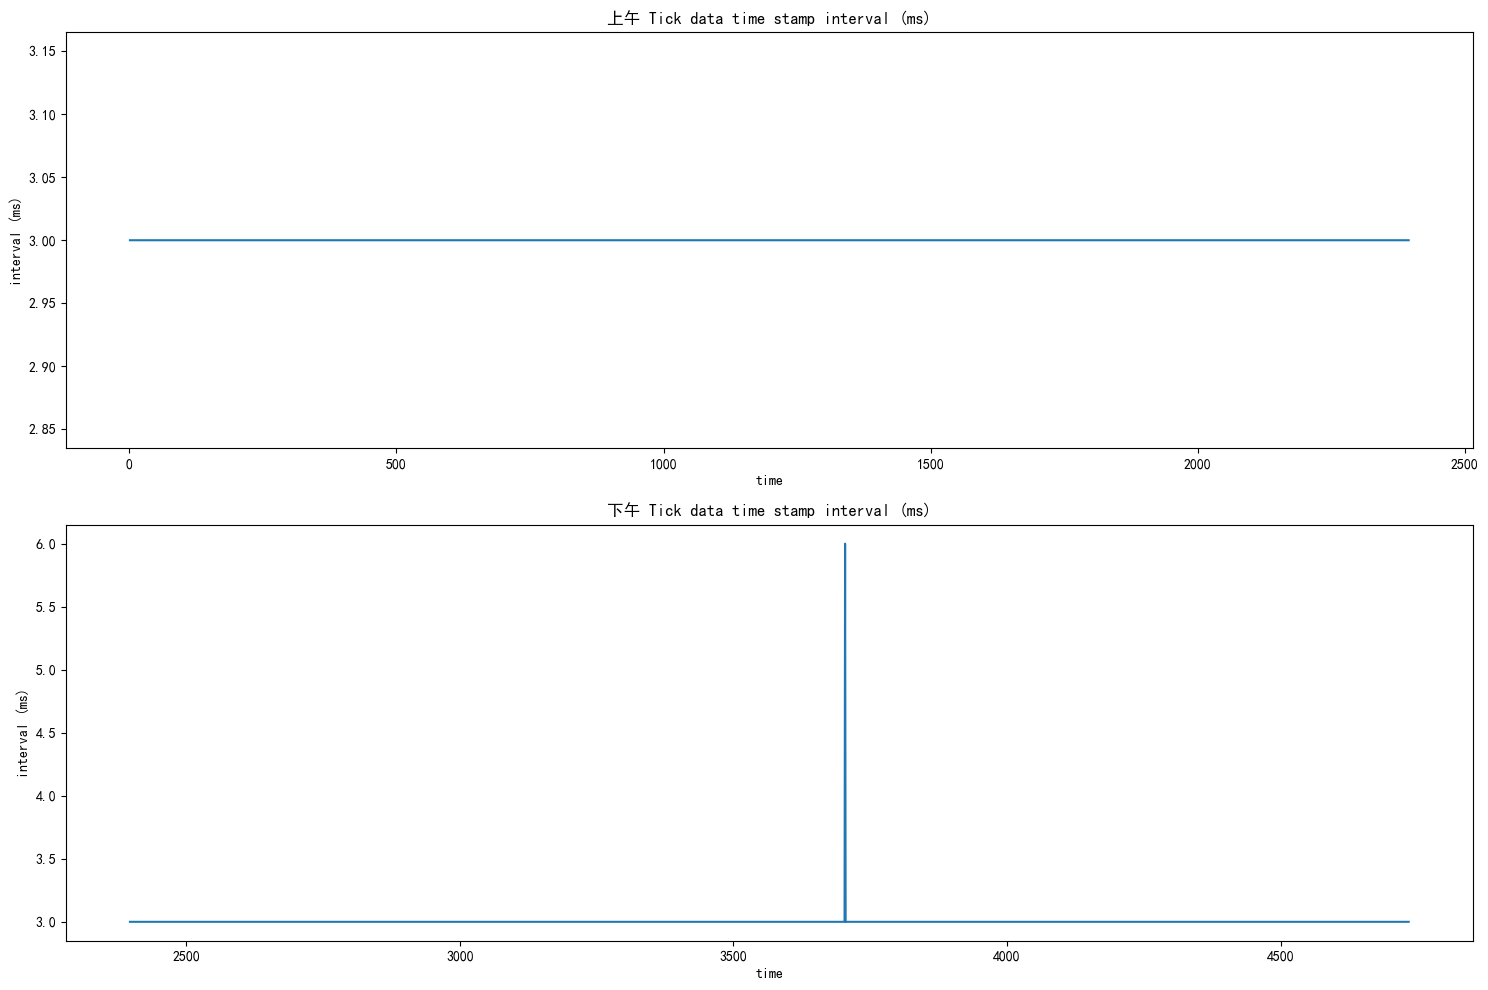

=== 上午数据分析 ===
发现 0 处可能的数据缺失 (时间间隔过长)。
发现 0 处重复的时间戳。

=== 下午数据分析 ===
发现 0 处可能的数据缺失 (时间间隔过长)。
发现 0 处重复的时间戳。

=== 整体统计 ===
总共发现 0 处重复的时间戳。

=== 下午 time_delta_s != 3 的记录 ===
                      时间  time_delta_s
3704 2024-04-22 14:05:28           6.0


In [13]:
# 这是高频数据质量的核心！检查数据流是否连续稳定。

# 按照上午下午进行区分
raw_data['hour'] = raw_data['时间'].dt.hour
morning_data = raw_data[raw_data['hour'] < 12]  # 上午数据
afternoon_data = raw_data[raw_data['hour'] >= 12]  # 下午数据

# 分别计算上午和下午的时间间隔
if not morning_data.empty:
    morning_data = morning_data.copy()
    morning_data['time_delta_s'] = morning_data['时间'].diff().dt.total_seconds()

if not afternoon_data.empty:
    afternoon_data = afternoon_data.copy()
    afternoon_data['time_delta_s'] = afternoon_data['时间'].diff().dt.total_seconds()

# 分别绘制上午和下午的时间间隔图
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 上午数据
if not morning_data.empty:
    axes[0].plot(morning_data.index, morning_data['time_delta_s'])
    axes[0].set_title('上午 Tick data time stamp interval (ms)')
    axes[0].set_xlabel('time')
    axes[0].set_ylabel('interval (ms)')
    # axes[0].set_yscale('log')

# 下午数据
if not afternoon_data.empty:
    axes[1].plot(afternoon_data.index, afternoon_data['time_delta_s'])
    axes[1].set_title('下午 Tick data time stamp interval (ms)')
    axes[1].set_xlabel('time')
    axes[1].set_ylabel('interval (ms)')
    # axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# 分别查找上午和下午的异常时间间隔
print("=== 上午数据分析 ===")
if not morning_data.empty:
    morning_time_gaps = morning_data[morning_data['time_delta_s'] > morning_data['time_delta_s'].median() * 10]
    morning_duplicate_timestamps = morning_data[morning_data.index.duplicated(keep=False)]
    
    print(f"发现 {len(morning_time_gaps)} 处可能的数据缺失 (时间间隔过长)。")
    if not morning_time_gaps.empty:
        print("最大时间间隔记录:")
        print(morning_time_gaps.nlargest(3, 'time_delta_s')[['time_delta_s', '时间']])
    
    print(f"发现 {len(morning_duplicate_timestamps)} 处重复的时间戳。")
    if not morning_duplicate_timestamps.empty:
        print("重复时间戳详情:")
        print(morning_duplicate_timestamps[['时间']])
else:
    print("无上午数据")

print("\n=== 下午数据分析 ===")
if not afternoon_data.empty:
    afternoon_time_gaps = afternoon_data[afternoon_data['time_delta_s'] > afternoon_data['time_delta_s'].median() * 10]
    afternoon_duplicate_timestamps = afternoon_data[afternoon_data.index.duplicated(keep=False)]
    
    print(f"发现 {len(afternoon_time_gaps)} 处可能的数据缺失 (时间间隔过长)。")
    if not afternoon_time_gaps.empty:
        print("最大时间间隔记录:")
        print(afternoon_time_gaps.nlargest(3, 'time_delta_s')[['time_delta_s', '时间']])
    
    print(f"发现 {len(afternoon_duplicate_timestamps)} 处重复的时间戳。")
    if not afternoon_duplicate_timestamps.empty:
        print("重复时间戳详情:")
        print(afternoon_duplicate_timestamps[['时间']])
else:
    print("无下午数据")

# 整体统计
all_time_gaps_count = 0
all_duplicate_timestamps_count = 0

if not morning_data.empty:
    morning_time_gaps = morning_data[morning_data['time_delta_s'] > morning_data['time_delta_s'].median() * 10]
    morning_duplicate_timestamps = morning_data[morning_data.index.duplicated(keep=False)]
    all_time_gaps_count += len(morning_time_gaps)
    all_duplicate_timestamps_count += len(morning_duplicate_timestamps)

if not afternoon_data.empty:
    afternoon_time_gaps = afternoon_data[afternoon_data['time_delta_s'] > afternoon_data['time_delta_s'].median() * 10]
    afternoon_duplicate_timestamps = afternoon_data[afternoon_data.index.duplicated(keep=False)]
    all_time_gaps_count += len(afternoon_time_gaps)
    all_duplicate_timestamps_count += len(afternoon_duplicate_timestamps)

print(f"\n=== 整体统计 ===")
print(f"总共发现 {all_duplicate_timestamps_count} 处重复的时间戳。")
# 输出上午、下午 time_delta_s > 3 的数据
if not morning_data.empty:
    morning_large_gaps = morning_data[(morning_data['time_delta_s'] != 3) & (~morning_data['time_delta_s'].isna())]
    if not morning_large_gaps.empty:
        print("\n=== 上午 time_delta_s != 3 的记录 ===")
        print(morning_large_gaps[['时间', 'time_delta_s']])

if not afternoon_data.empty:
    afternoon_large_gaps = afternoon_data[(afternoon_data['time_delta_s'] != 3) & (~afternoon_data['time_delta_s'].isna())]
    if not afternoon_large_gaps.empty:
        print("\n=== 下午 time_delta_s != 3 的记录 ===")
        print(afternoon_large_gaps[['时间', 'time_delta_s']])


In [14]:
# 检查所有数量字段是否都为正
quantity_columns = [col for col in raw_data.columns if ('量' in col and 'BASE' in col)]

for col in quantity_columns:
    if (raw_data[col] <= 0).any():
        print(f"警告：字段 {col} 存在非正数值！")
        print(raw_data[raw_data[col] <= 0][['时间', col]].head())
    # else:
    #     print(f"字段 {col} 检查通过，全部为正数。")


In [15]:
# 函数：检测异常值（使用 IQR 方法）
def detect_outliers(df, column):
    """
    使用 IQR 方法检测指定列的异常值。
    返回异常值的 DataFrame。
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"{column} 异常值数量: {len(outliers)}")
    return outliers



# 存储所有异常值信息
all_outliers = 0
outlier_info = {}
for col in raw_data.columns:
    outliers = detect_outliers(raw_data, col)
    outlier_info[col] = outliers
    all_outliers += len(outliers)

print(f'异常值总数: {all_outliers} 占比: {100 * all_outliers / (len(raw_data) * len(raw_data.columns)):.2f}%')

BASE卖1价 异常值数量: 210
BASE卖1量 异常值数量: 38
BASE买1价 异常值数量: 210
BASE买1量 异常值数量: 0
BASE卖2价 异常值数量: 210
BASE卖2量 异常值数量: 0
BASE买2价 异常值数量: 210
BASE买2量 异常值数量: 0
BASE卖3价 异常值数量: 210
BASE卖3量 异常值数量: 58
BASE买3价 异常值数量: 210
BASE买3量 异常值数量: 140
BASE卖4价 异常值数量: 210
BASE卖4量 异常值数量: 45
BASE买4价 异常值数量: 210
BASE买4量 异常值数量: 0
BASE卖5价 异常值数量: 210
BASE卖5量 异常值数量: 259
BASE买5价 异常值数量: 210
BASE买5量 异常值数量: 0
BASE卖6价 异常值数量: 210
BASE卖6量 异常值数量: 1041
BASE买6价 异常值数量: 210
BASE买6量 异常值数量: 739
BASE卖7价 异常值数量: 210
BASE卖7量 异常值数量: 0
BASE买7价 异常值数量: 210
BASE买7量 异常值数量: 164
BASE卖8价 异常值数量: 210
BASE卖8量 异常值数量: 0
BASE买8价 异常值数量: 210
BASE买8量 异常值数量: 0
BASE卖9价 异常值数量: 210
BASE卖9量 异常值数量: 362
BASE买9价 异常值数量: 210
BASE买9量 异常值数量: 2
BASE卖10价 异常值数量: 210
BASE卖10量 异常值数量: 0
BASE买10价 异常值数量: 210
BASE买10量 异常值数量: 23
EXT_mid_price 异常值数量: 210
EXT_relative_spread_l1 异常值数量: 287
EXT_micro_price 异常值数量: 361
EXT_total_depth_vol 异常值数量: 58
EXT_depth_imbalance 异常值数量: 0
EXT_wap_bid 异常值数量: 534
EXT_wap_ask 异常值数量: 383
EXT_weighted_mid_price_v1 异常值数量: 487
EXT_weighted_mid_price_v2 异常值数量

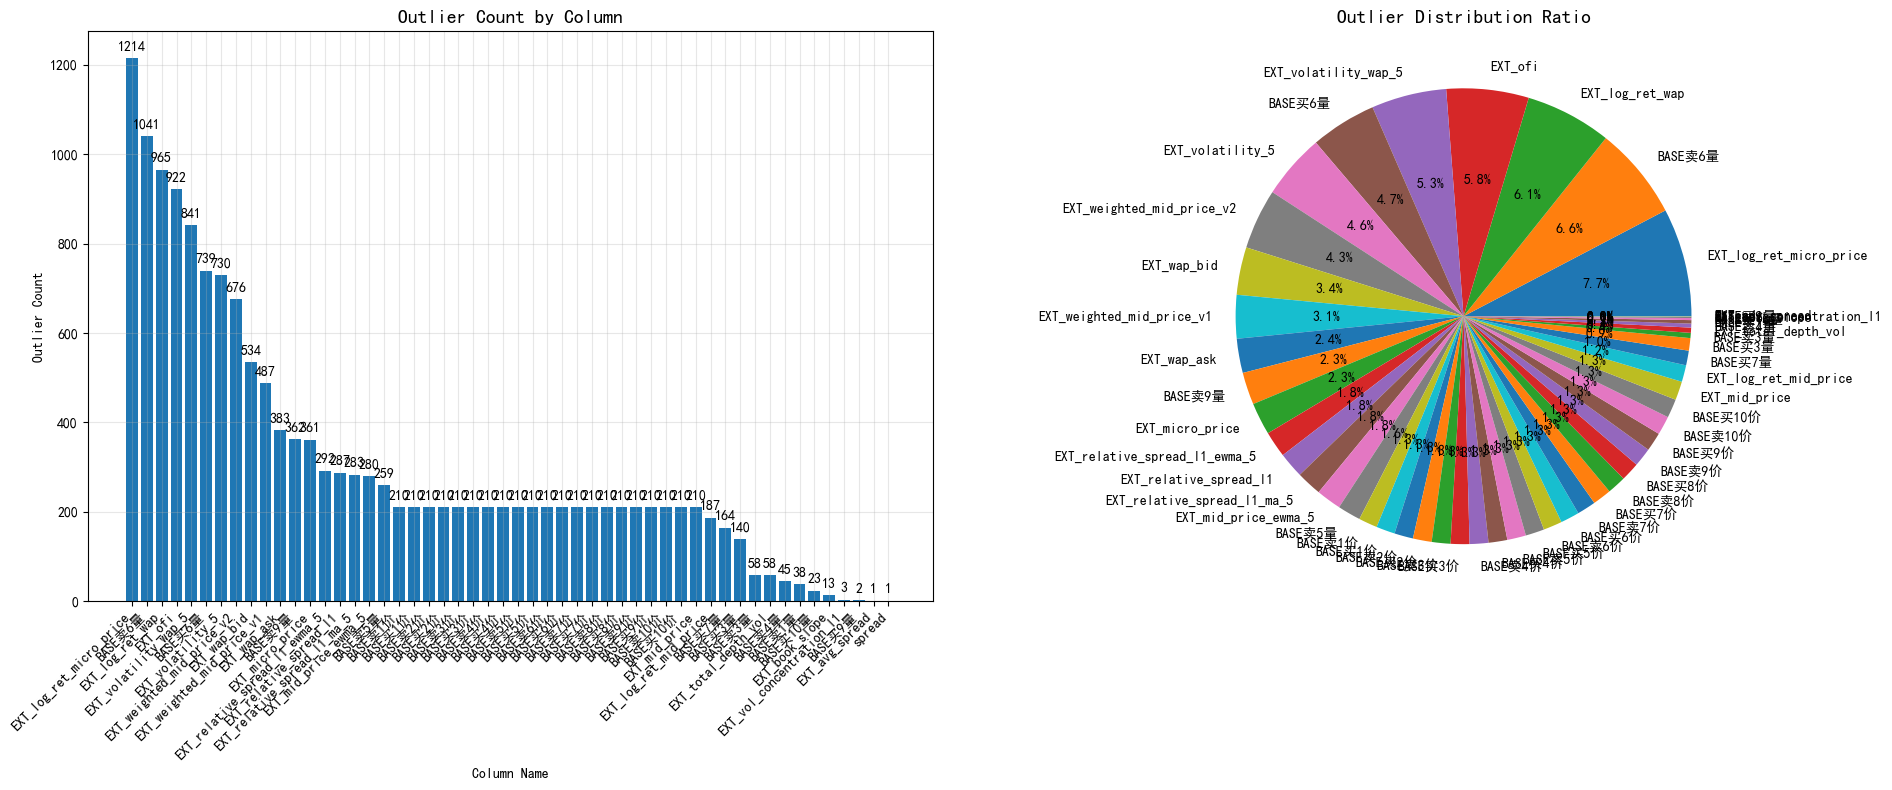

In [16]:
# ========== 异常值可视化分析 ==========

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 1. 异常值数量统计图
plt.figure(figsize=(20, 8))
outlier_counts = {col: len(outliers) for col, outliers in outlier_info.items()}
outlier_counts_sorted = dict(sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True))

# 只显示有异常值的列
outlier_counts_filtered = {k: v for k, v in outlier_counts_sorted.items() if v > 0}

plt.subplot(1, 2, 1)
bars = plt.bar(range(len(outlier_counts_filtered)), list(outlier_counts_filtered.values()))
plt.title('Outlier Count by Column', fontsize=14, fontweight='bold')
plt.xlabel('Column Name')
plt.ylabel('Outlier Count')
plt.xticks(range(len(outlier_counts_filtered)), list(outlier_counts_filtered.keys()), rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# 在柱状图上添加数值标签
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(outlier_counts_filtered.values())*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

# 异常值比例饼图
plt.subplot(1, 2, 2)
total_outliers = sum(outlier_counts_filtered.values())
if total_outliers > 0:
    plt.pie(outlier_counts_filtered.values(), labels=outlier_counts_filtered.keys(), autopct='%1.1f%%')
    plt.title('Outlier Distribution Ratio', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


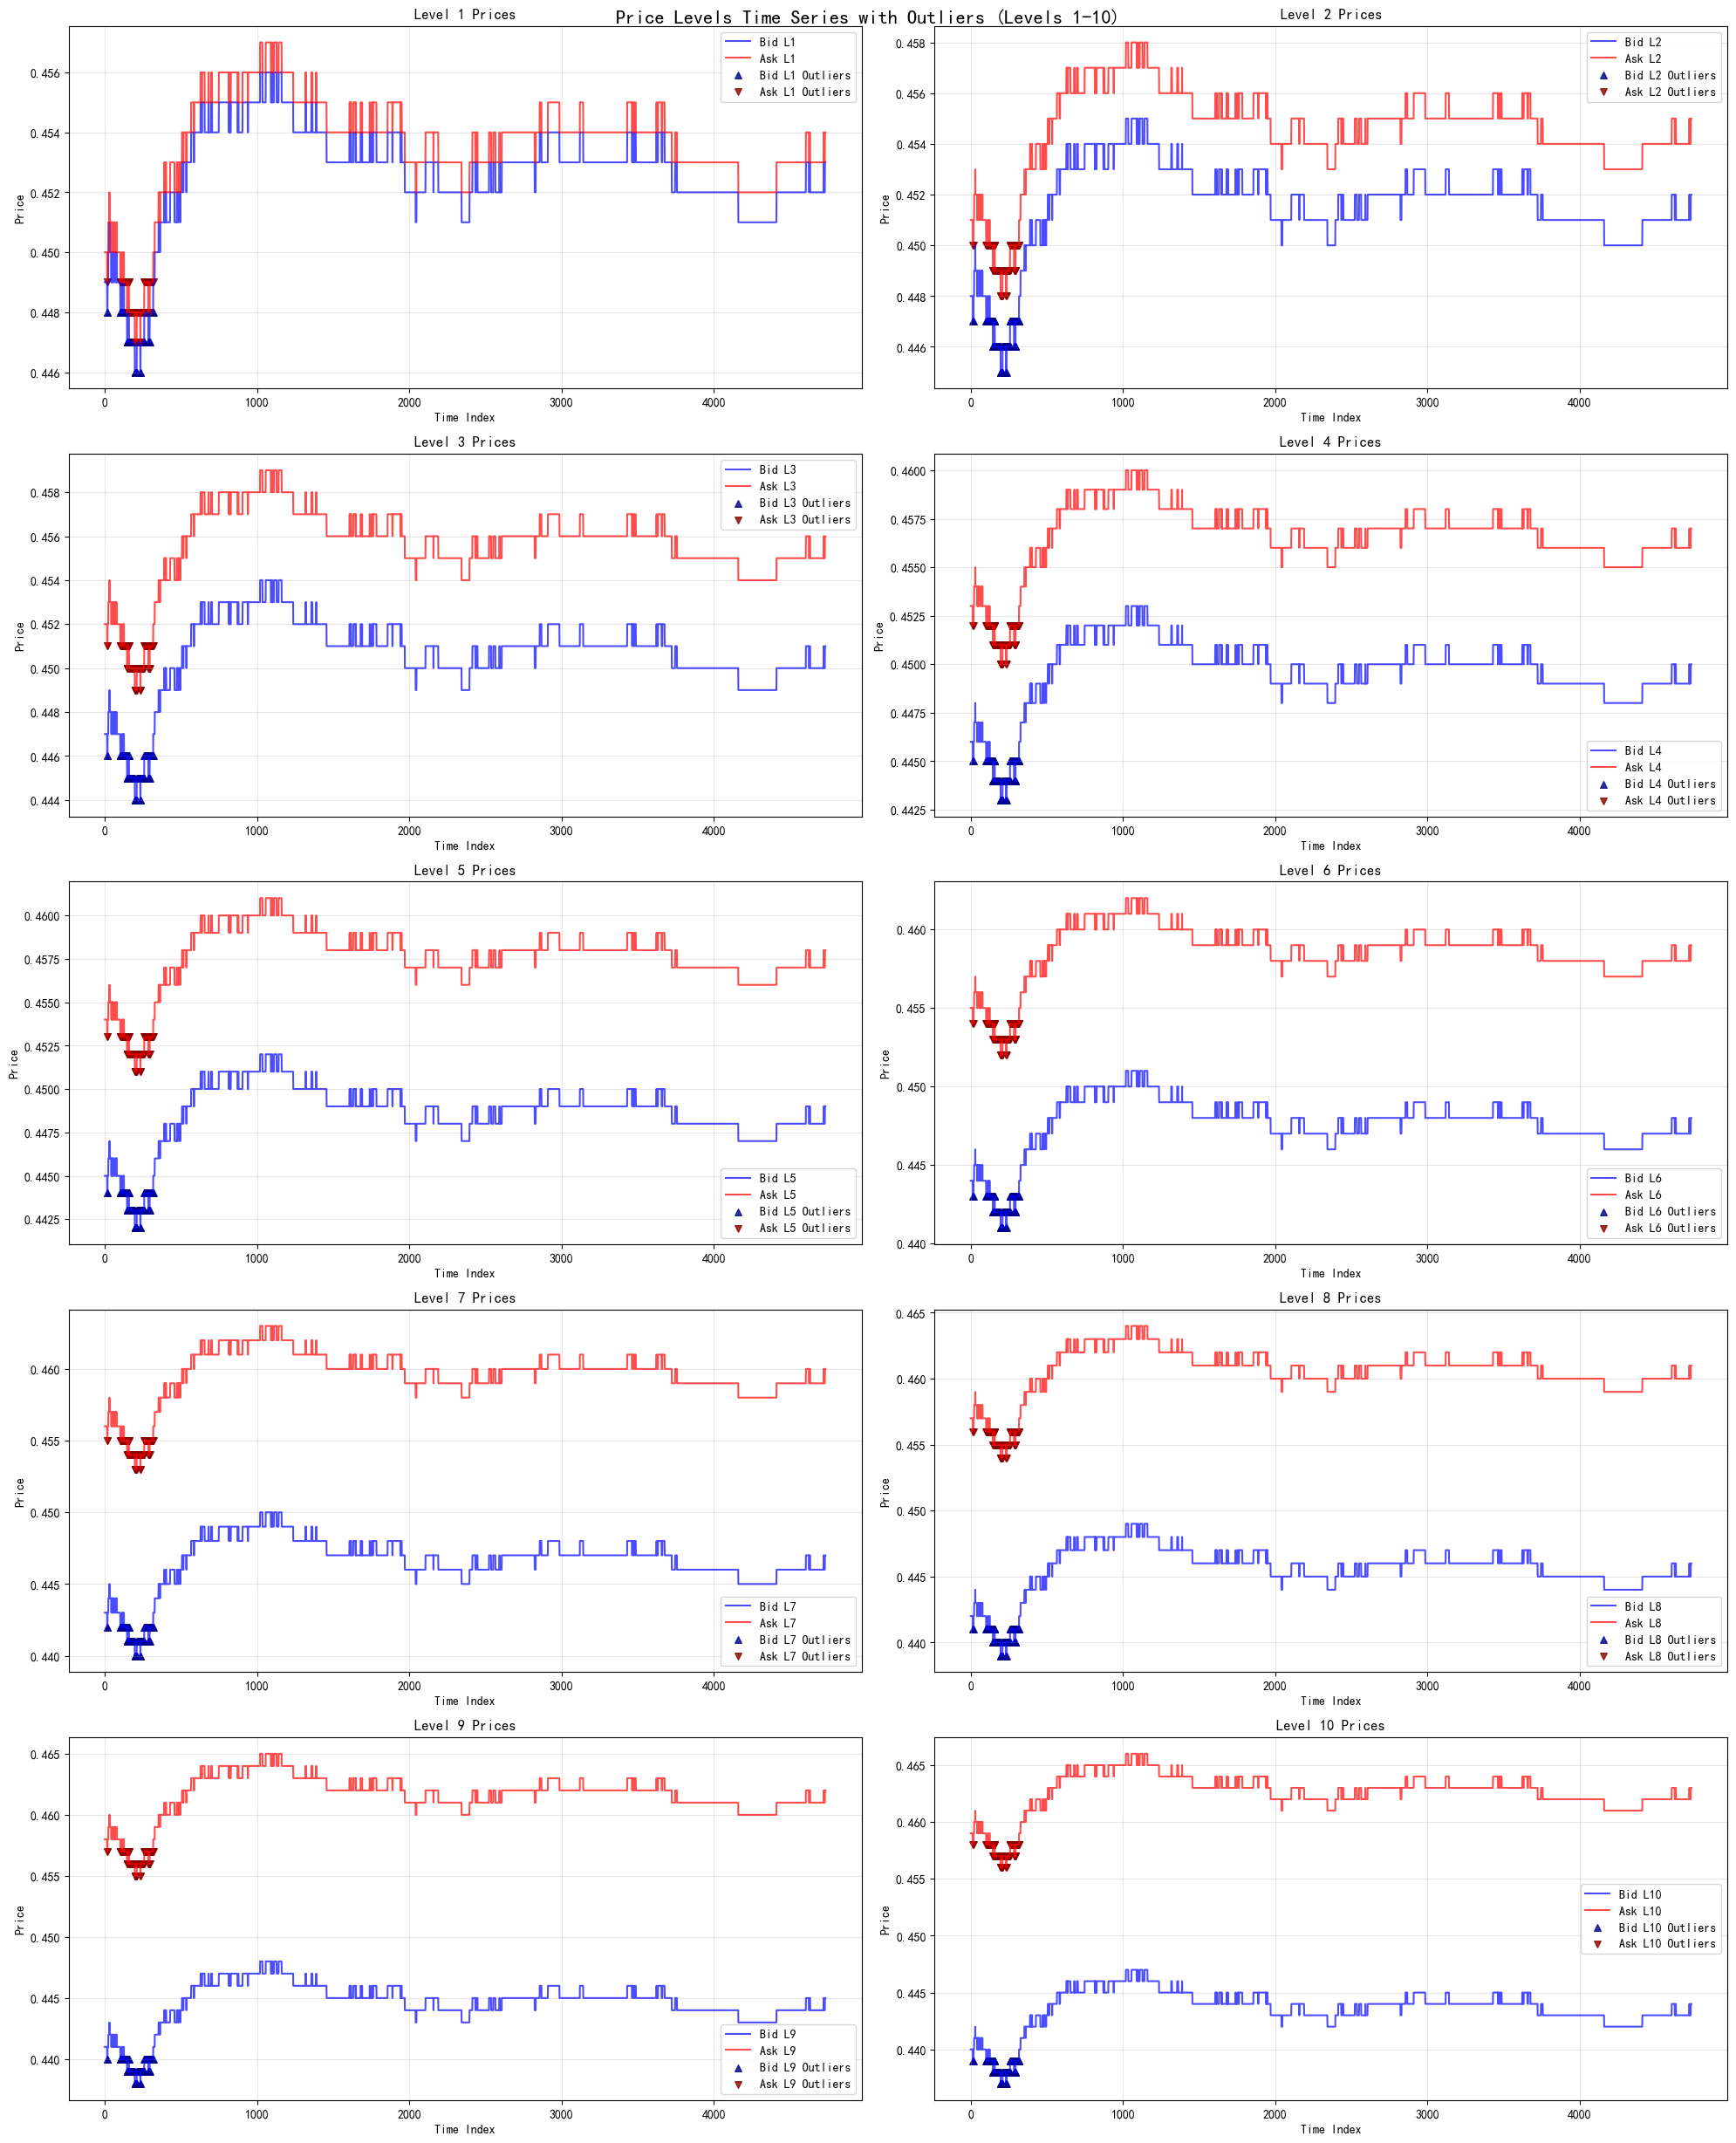

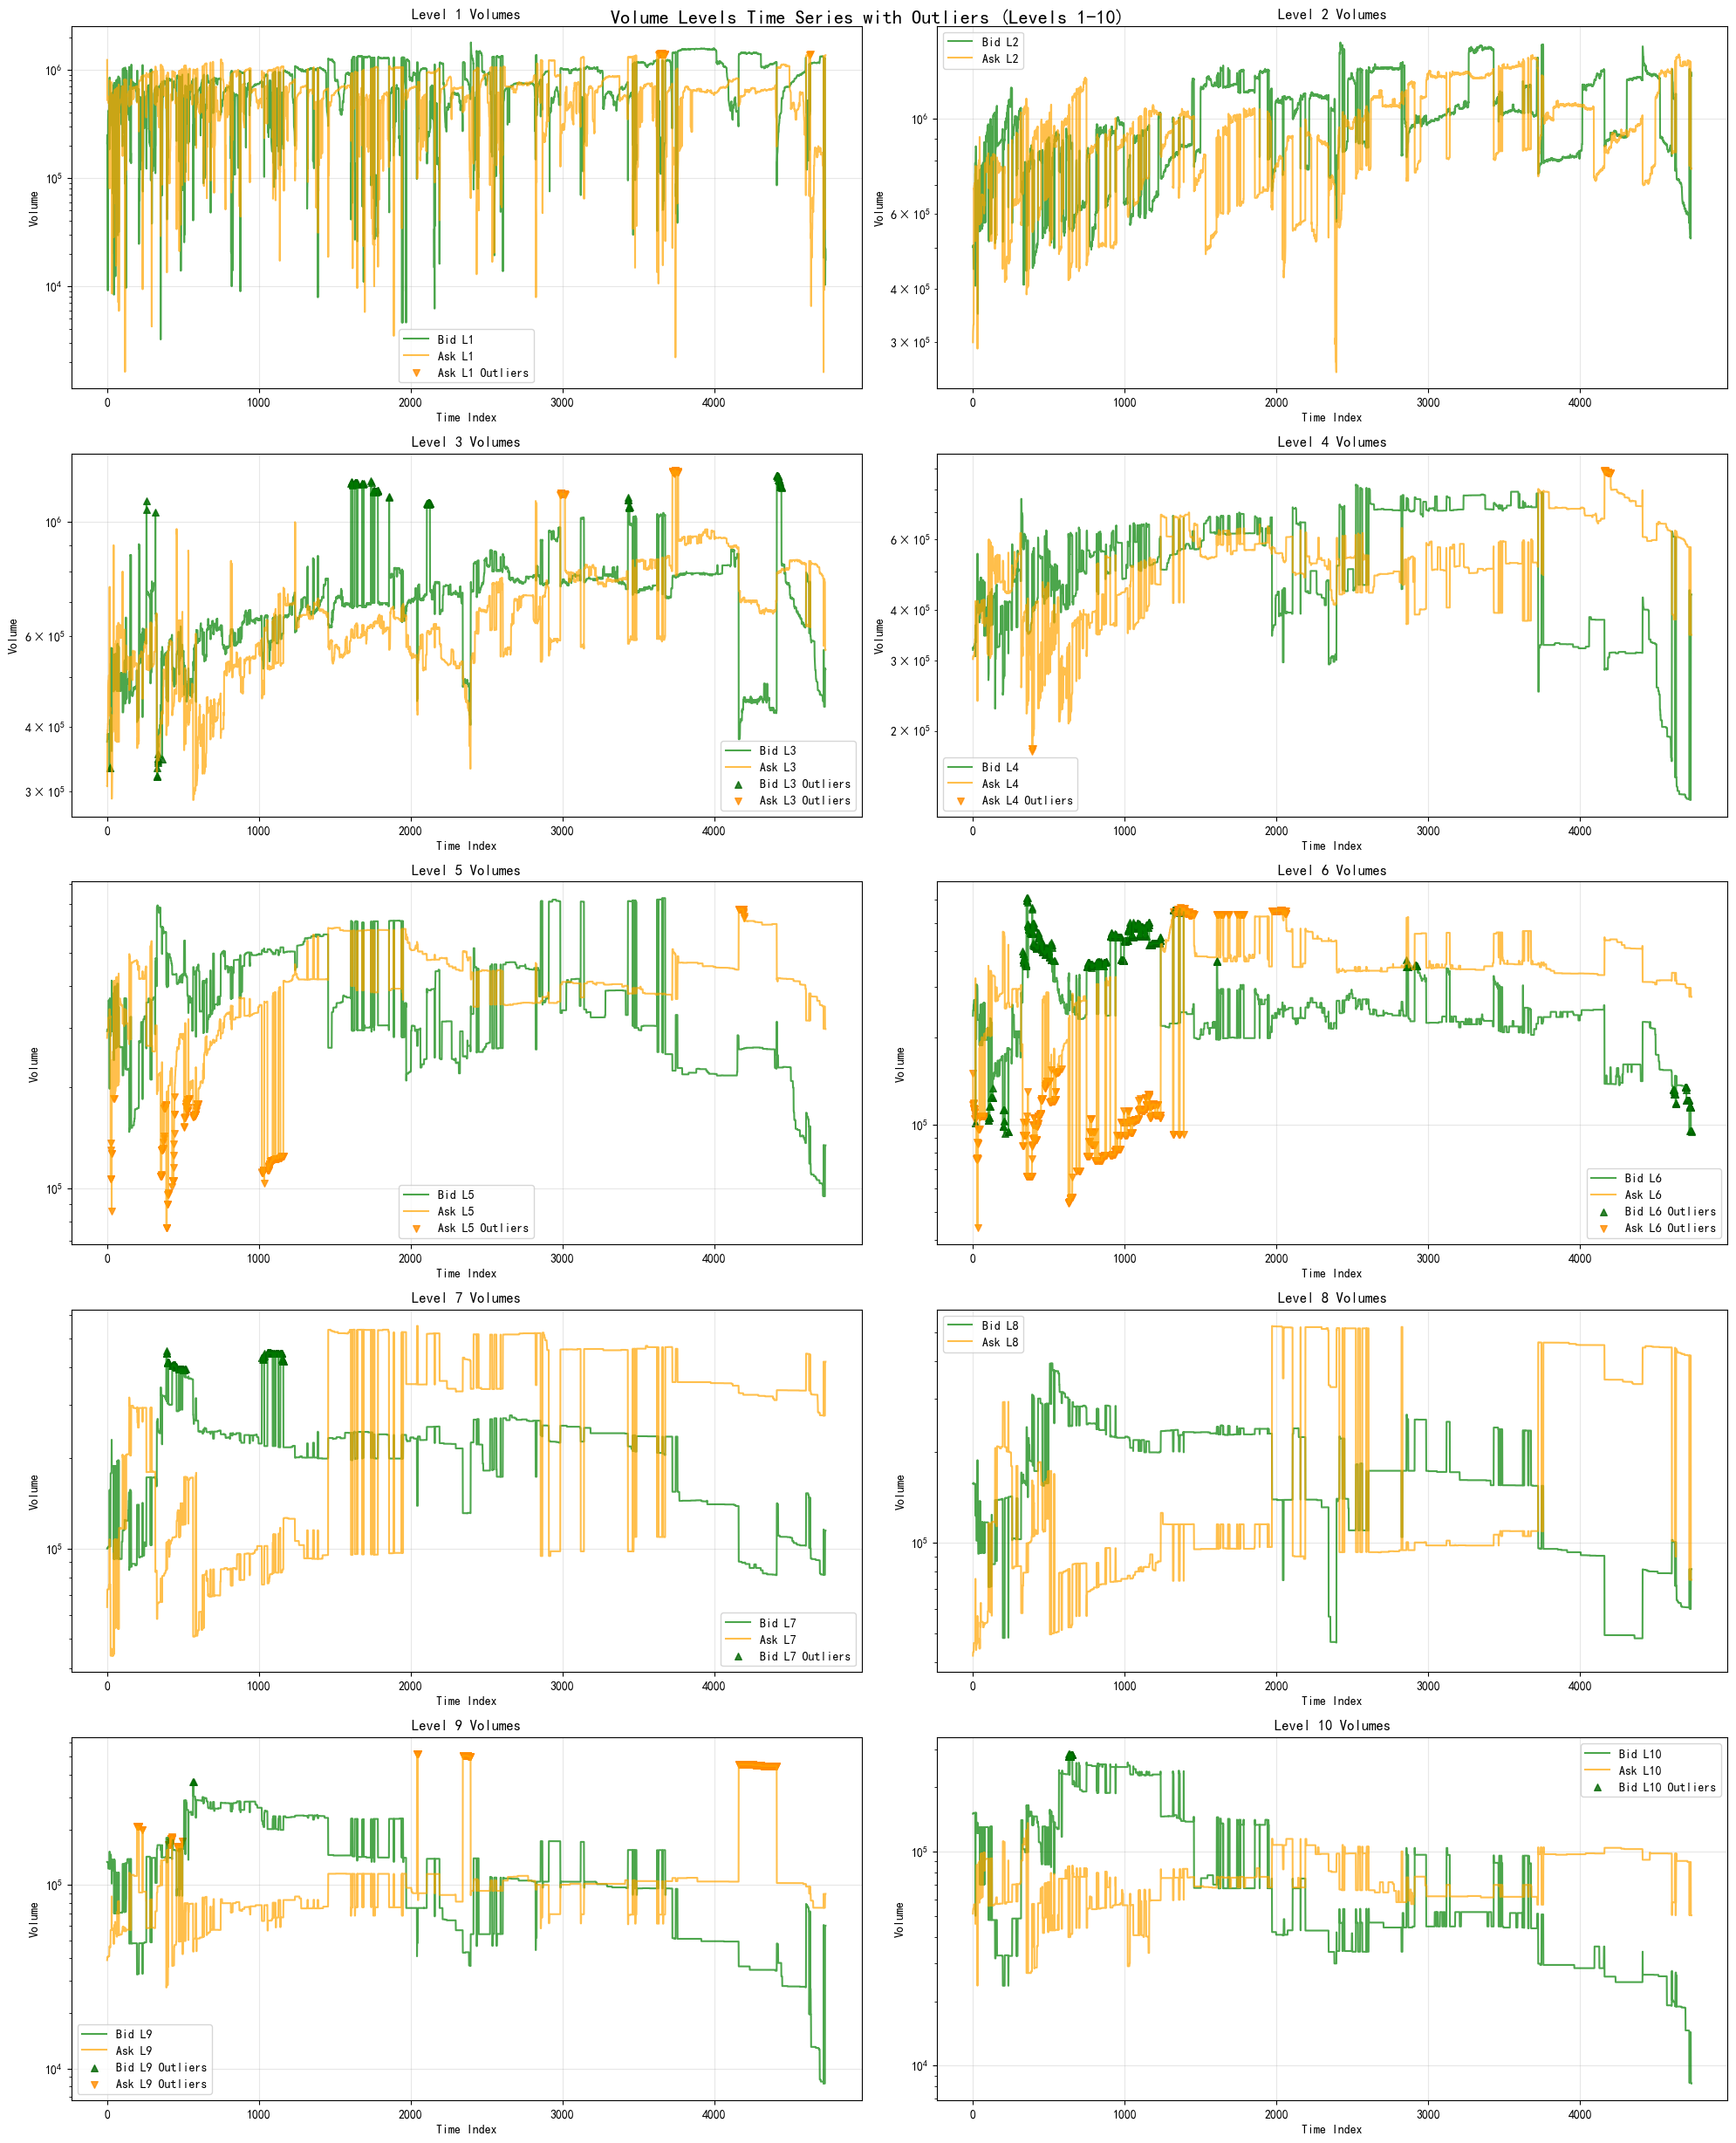

In [17]:

# 2. 价格档位时间序列分析（1-10档全部绘制）
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
fig.suptitle('Price Levels Time Series with Outliers (Levels 1-10)', fontsize=16, fontweight='bold')

for level in range(1, 11):
    row = (level - 1) // 2
    col = (level - 1) % 2
    
    bid_price_col = f'BASE买{level}价'
    ask_price_col = f'BASE卖{level}价'
    
    # 绘制买卖价格时间序列
    axes[row, col].plot(raw_data.index, raw_data[bid_price_col], label=f'Bid L{level}', color='blue', alpha=0.7)
    axes[row, col].plot(raw_data.index, raw_data[ask_price_col], label=f'Ask L{level}', color='red', alpha=0.7)
    
    # 标注异常值
    if bid_price_col in outlier_info:
        bid_outliers = outlier_info[bid_price_col]
        if len(bid_outliers) > 0:
            axes[row, col].scatter(bid_outliers.index, bid_outliers[bid_price_col], 
                                 color='darkblue', s=30, alpha=0.8, marker='^', label=f'Bid L{level} Outliers')
    
    if ask_price_col in outlier_info:
        ask_outliers = outlier_info[ask_price_col]
        if len(ask_outliers) > 0:
            axes[row, col].scatter(ask_outliers.index, ask_outliers[ask_price_col], 
                                 color='darkred', s=30, alpha=0.8, marker='v', label=f'Ask L{level} Outliers')
    
    axes[row, col].set_title(f'Level {level} Prices', fontsize=12)
    axes[row, col].set_xlabel('Time Index')
    axes[row, col].set_ylabel('Price')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. 量档位时间序列分析（1-10档全部绘制）
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
fig.suptitle('Volume Levels Time Series with Outliers (Levels 1-10)', fontsize=16, fontweight='bold')

for level in range(1, 11):
    row = (level - 1) // 2
    col = (level - 1) % 2
    
    bid_vol_col = f'BASE买{level}量'
    ask_vol_col = f'BASE卖{level}量'
    
    # 绘制买卖量时间序列（使用对数坐标轴）
    axes[row, col].plot(raw_data.index, raw_data[bid_vol_col], label=f'Bid L{level}', color='green', alpha=0.7)
    axes[row, col].plot(raw_data.index, raw_data[ask_vol_col], label=f'Ask L{level}', color='orange', alpha=0.7)
    
    # 标注异常值
    if bid_vol_col in outlier_info:
        bid_outliers = outlier_info[bid_vol_col]
        if len(bid_outliers) > 0:
            axes[row, col].scatter(bid_outliers.index, bid_outliers[bid_vol_col], 
                                 color='darkgreen', s=30, alpha=0.8, marker='^', label=f'Bid L{level} Outliers')
    
    if ask_vol_col in outlier_info:
        ask_outliers = outlier_info[ask_vol_col]
        if len(ask_outliers) > 0:
            axes[row, col].scatter(ask_outliers.index, ask_outliers[ask_vol_col], 
                                 color='darkorange', s=30, alpha=0.8, marker='v', label=f'Ask L{level} Outliers')
    
    axes[row, col].set_title(f'Level {level} Volumes', fontsize=12)
    axes[row, col].set_xlabel('Time Index')
    axes[row, col].set_ylabel('Volume')
    axes[row, col].set_yscale('log')  # 使用对数坐标轴
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


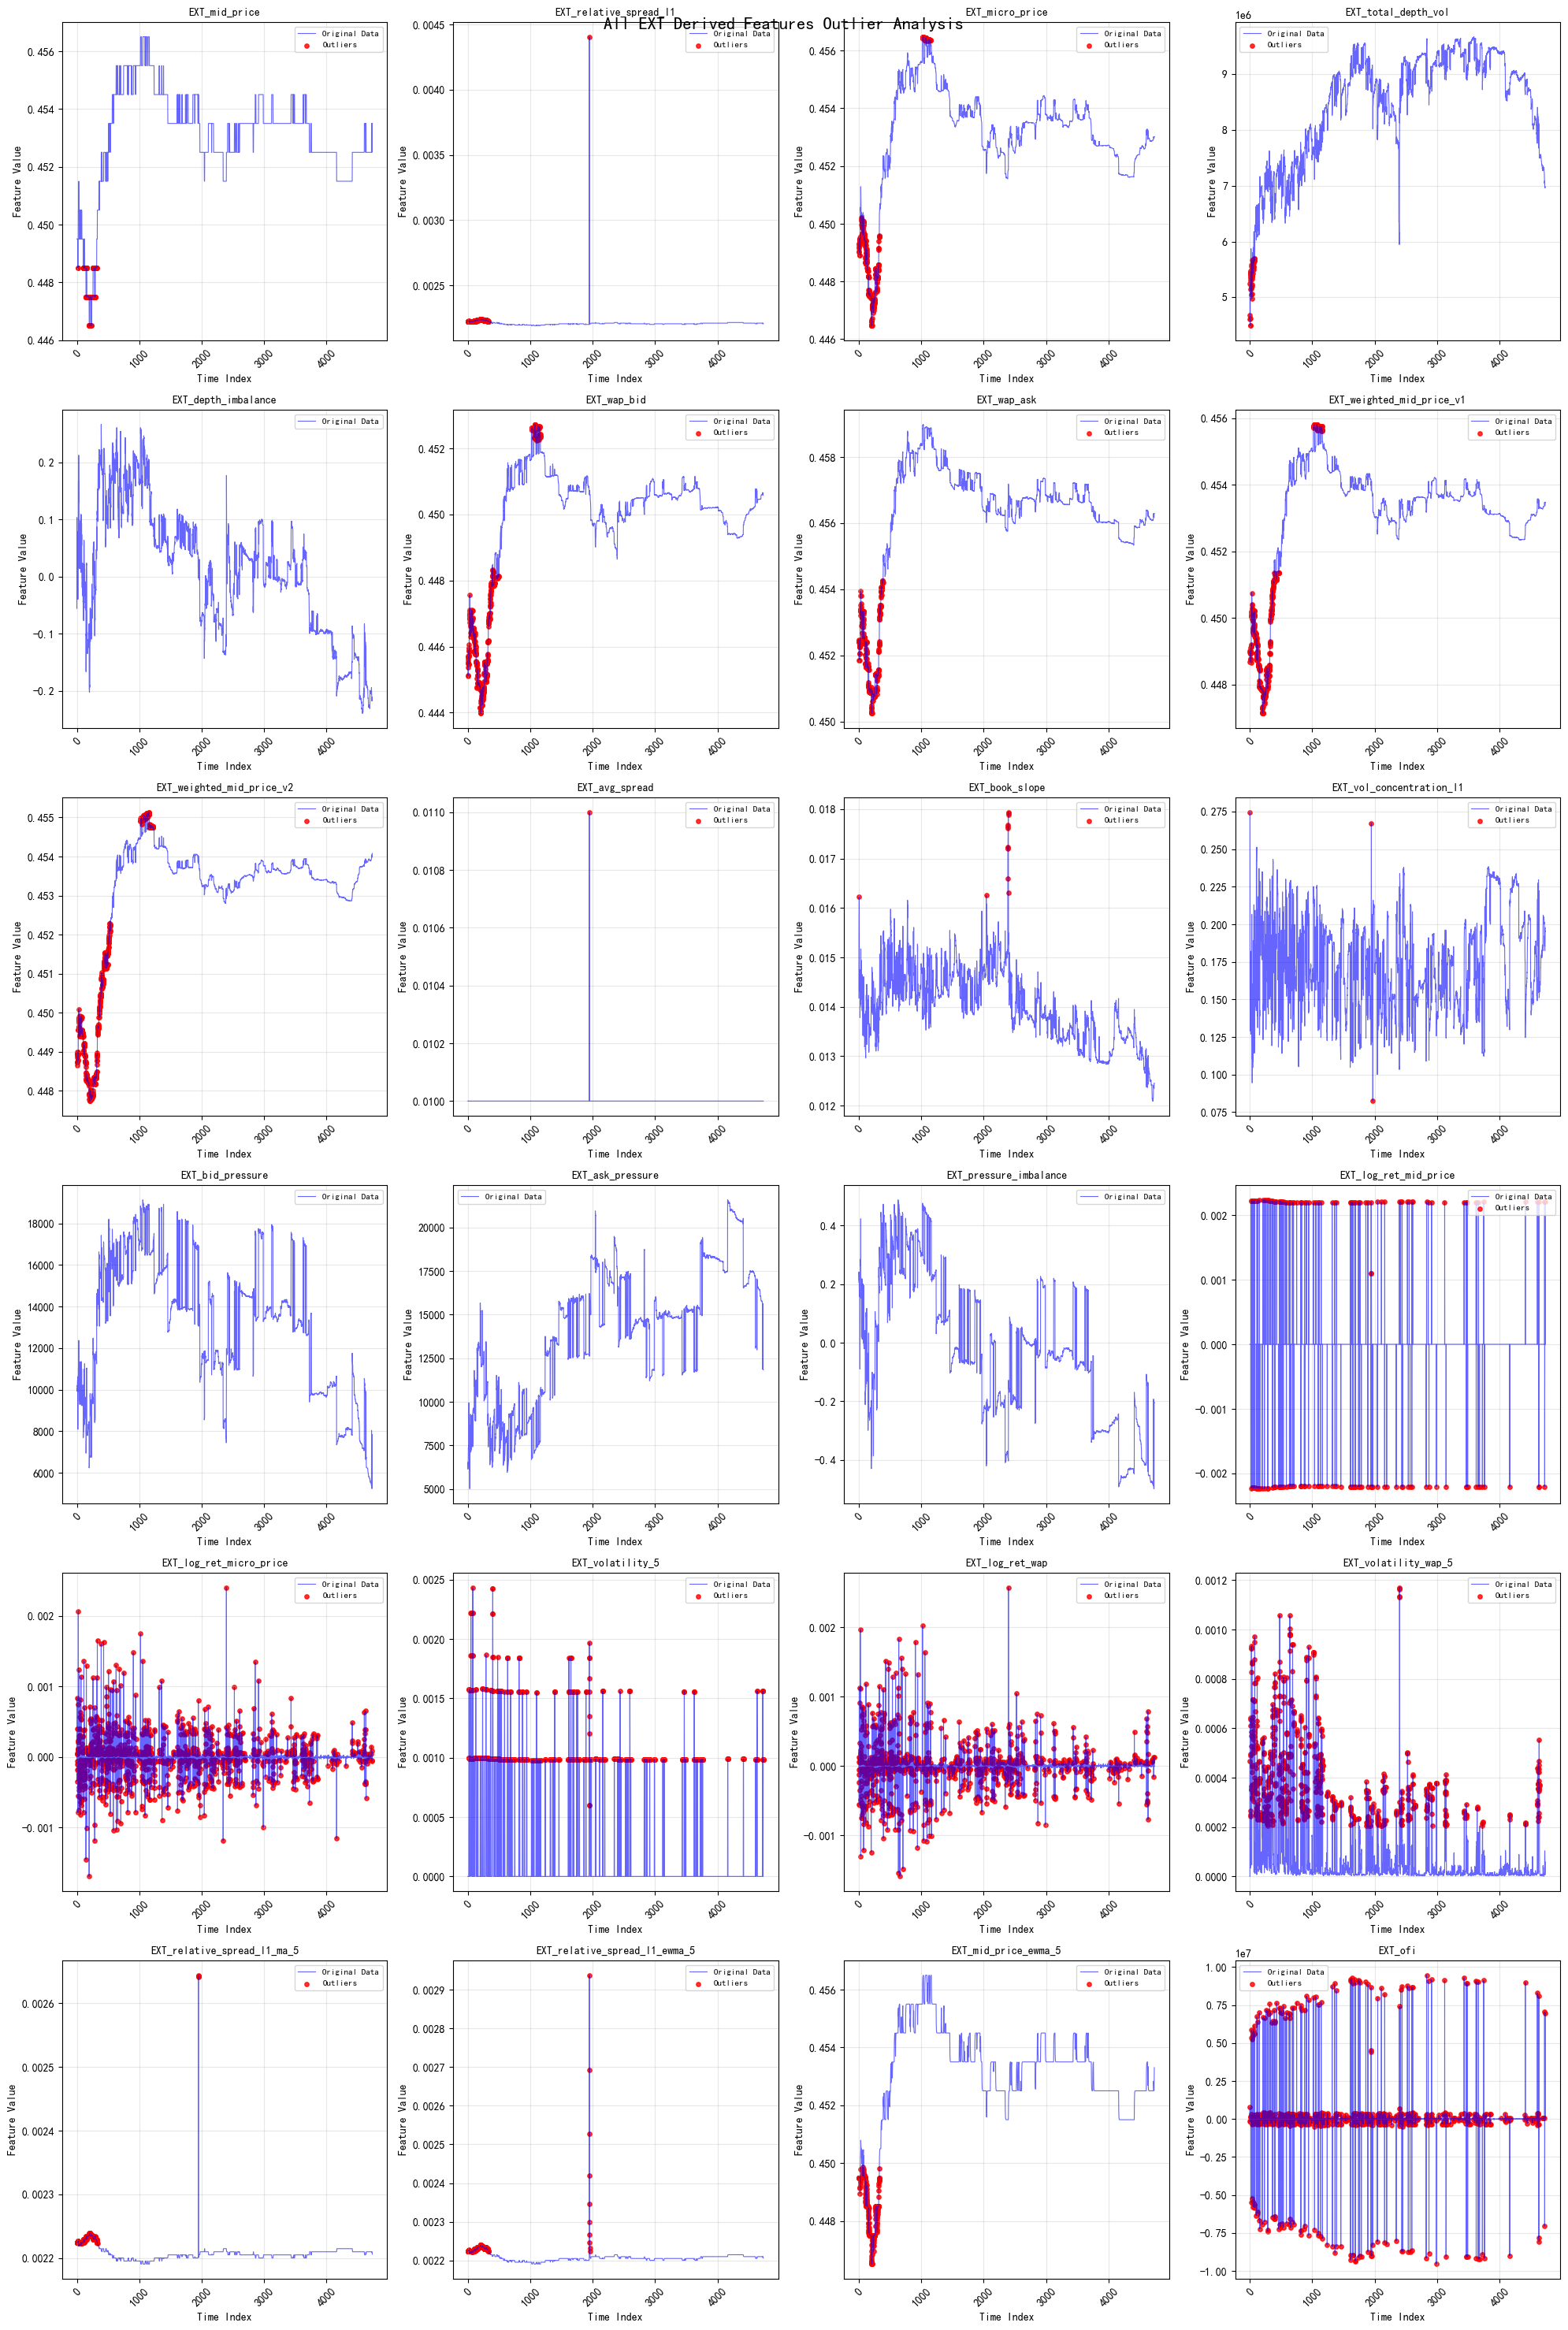


EXT Derived Features Outlier Summary

总共发现 20 个衍生特征存在异常值:
                      Feature  Outlier_Count  Outlier_Ratio_%     Min_Value     Max_Value   Mean_Value    Std_Value
      EXT_log_ret_micro_price           1214            25.64 -1.691000e-03 -1.691000e-03 2.000000e-06 1.870000e-04
              EXT_log_ret_wap            965            20.38 -1.595000e-03 -1.595000e-03 2.000000e-06 1.930000e-04
                      EXT_ofi            922            19.47 -9.551384e+06 -9.551384e+06 4.671043e+03 1.543478e+06
         EXT_volatility_wap_5            841            17.76  0.000000e+00  0.000000e+00 9.800000e-05 1.710000e-04
             EXT_volatility_5            730            15.42  0.000000e+00  0.000000e+00 1.730000e-04 4.210000e-04
    EXT_weighted_mid_price_v2            676            14.28  4.477330e-01  4.477330e-01 4.531890e-01 1.438000e-03
                  EXT_wap_bid            534            11.28  4.439760e-01  4.439760e-01 4.500560e-01 1.507000e-03
    EXT_weigh

<Figure size 1500x1000 with 0 Axes>

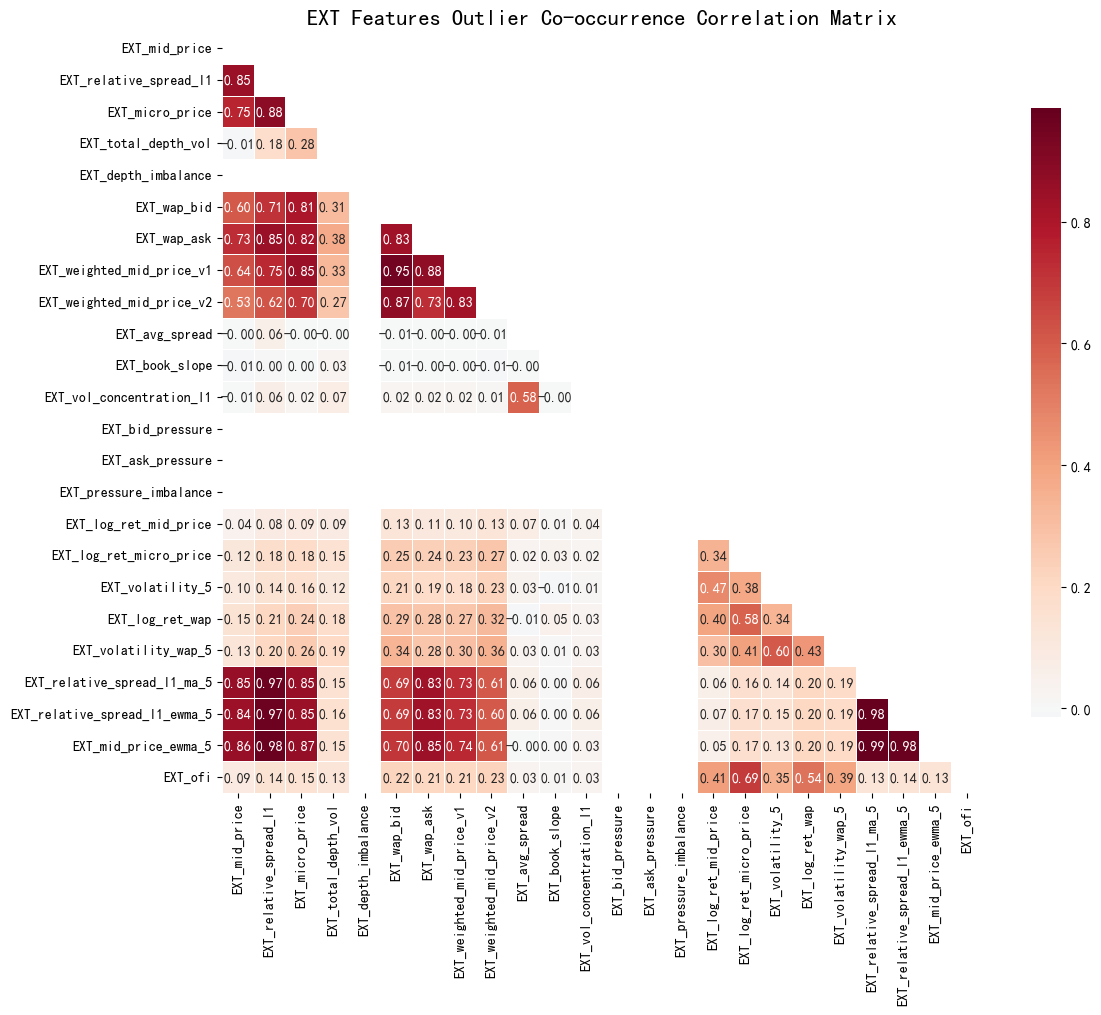

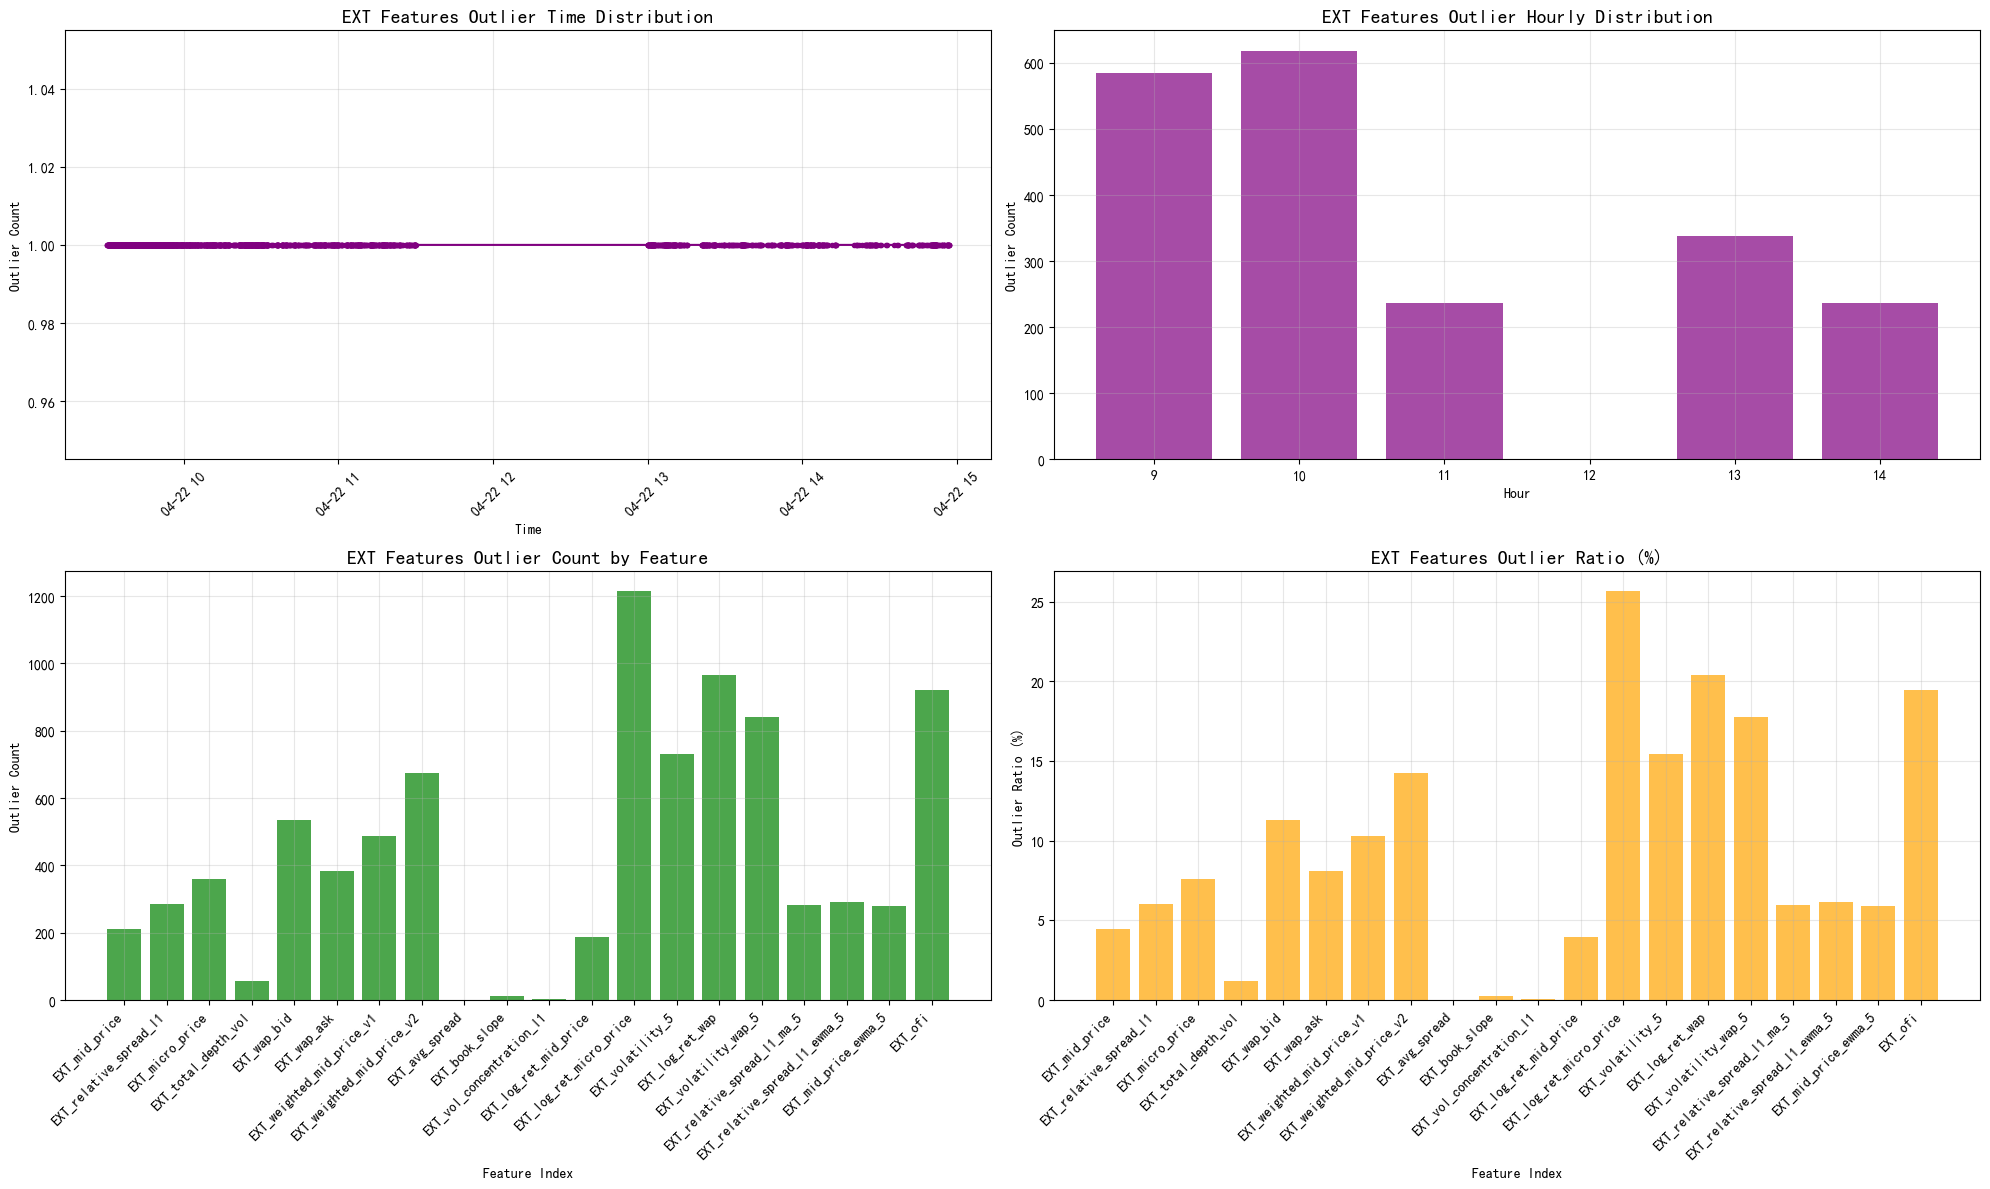

In [18]:
# 4. 衍生特征异常值分析 - 可视化所有EXT特征
derived_cols = [col for col in raw_data.columns if col.startswith('EXT_')]
if derived_cols:
    # 计算需要的子图数量
    n_features = len(derived_cols)
    n_cols = 4  # 每行4个图
    n_rows = (n_features + n_cols - 1) // n_cols  # 向上取整
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    fig.suptitle('All EXT Derived Features Outlier Analysis', fontsize=16, fontweight='bold')
    
    # 如果只有一行，确保axes是二维数组
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(derived_cols):
        row = i // n_cols
        col_idx = i % n_cols
        
        outliers = outlier_info[col]
        
        # 绘制时间序列，标记异常点
        axes[row, col_idx].plot(raw_data.index, raw_data[col], alpha=0.6, label='Original Data', color='blue', linewidth=0.8)
        if len(outliers) > 0:
            axes[row, col_idx].scatter(outliers.index, outliers[col], color='red', s=15, alpha=0.8, label='Outliers')
        
        axes[row, col_idx].set_title(f'{col}', fontsize=10)
        axes[row, col_idx].set_xlabel('Time Index')
        axes[row, col_idx].set_ylabel('Feature Value')
        axes[row, col_idx].legend(fontsize=8)
        axes[row, col_idx].grid(True, alpha=0.3)
        
        # 设置x轴标签旋转，避免重叠
        axes[row, col_idx].tick_params(axis='x', rotation=45)
    
    # 隐藏多余的子图
    for i in range(n_features, n_rows * n_cols):
        row = i // n_cols
        col_idx = i % n_cols
        axes[row, col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# 4.1 衍生特征异常值统计摘要
print("\n" + "="*80)
print("EXT Derived Features Outlier Summary")
print("="*80)

ext_outlier_summary = []
for col in derived_cols:
    outliers = outlier_info[col]
    outlier_count = len(outliers)
    if outlier_count > 0:
        outlier_ratio = outlier_count / len(raw_data) * 100
        ext_outlier_summary.append({
            'Feature': col,
            'Outlier_Count': outlier_count,
            'Outlier_Ratio_%': round(outlier_ratio, 2),
            'Min_Value': round(raw_data[col].min(), 6),
            'Max_Value': round(raw_data[col].min(), 6),
            'Mean_Value': round(raw_data[col].mean(), 6),
            'Std_Value': round(raw_data[col].std(), 6)
        })

# 按异常值数量排序
ext_outlier_summary.sort(key=lambda x: x['Outlier_Count'], reverse=True)

# 创建DataFrame并显示
if ext_outlier_summary:
    summary_df = pd.DataFrame(ext_outlier_summary)
    print(f"\n总共发现 {len(ext_outlier_summary)} 个衍生特征存在异常值:")
    print(summary_df.to_string(index=False))
    
    # 异常值最多的前5个特征
    print(f"\n异常值最多的前5个衍生特征:")
    for i, row in enumerate(ext_outlier_summary[:5]):
        print(f"{i+1:2d}. {row['Feature']:25s}: {row['Outlier_Count']:4d} 个异常值 ({row['Outlier_Ratio_%']:5.2f}%)")
else:
    print("所有衍生特征都没有异常值！")

# 4.2 衍生特征异常值分布热力图
plt.figure(figsize=(15, 10))

# 创建衍生特征异常值标记矩阵
ext_outlier_matrix = pd.DataFrame(index=raw_data.index, columns=derived_cols)
for col in derived_cols:
    outliers = outlier_info[col]
    ext_outlier_matrix.loc[:, col] = raw_data.index.isin(outliers.index).astype(int)

# 计算异常值共现矩阵
ext_outlier_corr = ext_outlier_matrix.corr()

# 绘制热力图
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(ext_outlier_corr, dtype=bool))
sns.heatmap(ext_outlier_corr, mask=mask, annot=True, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('EXT Features Outlier Co-occurrence Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 4.3 衍生特征异常值时间分布
plt.figure(figsize=(20, 12))

# 统计每个时间点的衍生特征异常值数量
ext_outlier_indices = set()
for col in derived_cols:
    outliers = outlier_info[col]
    ext_outlier_indices.update(outliers.index)

if ext_outlier_indices:
    ext_outlier_time_counts = raw_data.loc[list(ext_outlier_indices), '时间'].value_counts().sort_index()
    
    plt.subplot(2, 2, 1)
    plt.plot(ext_outlier_time_counts.index, ext_outlier_time_counts.values, marker='o', markersize=3, color='purple')
    plt.title('EXT Features Outlier Time Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Outlier Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 按小时统计异常值
    plt.subplot(2, 2, 2)
    ext_hourly_outliers = raw_data.loc[list(ext_outlier_indices), 'hour'].value_counts().sort_index()
    plt.bar(ext_hourly_outliers.index, ext_hourly_outliers.values, alpha=0.7, color='purple')
    plt.title('EXT Features Outlier Hourly Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Hour')
    plt.ylabel('Outlier Count')
    plt.grid(True, alpha=0.3)
    
    # 按特征类型统计异常值
    plt.subplot(2, 2, 3)
    feature_outlier_counts = {col: len(outlier_info[col]) for col in derived_cols if len(outlier_info[col]) > 0}
    if feature_outlier_counts:
        plt.bar(range(len(feature_outlier_counts)), list(feature_outlier_counts.values()), alpha=0.7, color='green')
        plt.title('EXT Features Outlier Count by Feature', fontsize=14, fontweight='bold')
        plt.xlabel('Feature Index')
        plt.ylabel('Outlier Count')
        plt.xticks(range(len(feature_outlier_counts)), list(feature_outlier_counts.keys()), rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
    
    # 异常值比例分布
    plt.subplot(2, 2, 4)
    outlier_ratios = [len(outlier_info[col])/len(raw_data)*100 for col in derived_cols if len(outlier_info[col]) > 0]
    feature_names = [col for col in derived_cols if len(outlier_info[col]) > 0]
    if outlier_ratios:
        plt.bar(range(len(outlier_ratios)), outlier_ratios, alpha=0.7, color='orange')
        plt.title('EXT Features Outlier Ratio (%)', fontsize=14, fontweight='bold')
        plt.xlabel('Feature Index')
        plt.ylabel('Outlier Ratio (%)')
        plt.xticks(range(len(outlier_ratios)), feature_names, rotation=45, ha='right')
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()